In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  200


['permutations/total_ring_mass=1.7099759466766957e-09_radial_width=0.0005_shear_viscosity=9.394443439884124e-13_sim_id=62_timesteps_per_output=3003_',
 'permutations/total_ring_mass=1.1349672651536721e-09_radial_width=0.0005_shear_viscosity=3.015274399935745e-11_sim_id=53_timesteps_per_output=62_',
 'permutations/total_ring_mass=2.0000000000000004e-08_radial_width=0.0005_shear_viscosity=1.7651113509036325e-12_sim_id=184_timesteps_per_output=18695_',
 'permutations/total_ring_mass=4.999999999999994e-10_radial_width=0.0005_shear_viscosity=5.665364961185365e-11_sim_id=15_timesteps_per_output=14_',
 'permutations/total_ring_mass=4.999999999999994e-10_radial_width=0.0005_shear_viscosity=1.4590812272681375e-10_sim_id=18_timesteps_per_output=5_']

In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import pandas as pd

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=4.999999999999994...
1       1  permutations/total_ring_mass=4.999999999999994...
2       2  permutations/total_ring_mass=4.999999999999994...
3       3  permutations/total_ring_mass=4.999999999999994...
4       4  permutations/total_ring_mass=4.999999999999994...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:68: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)


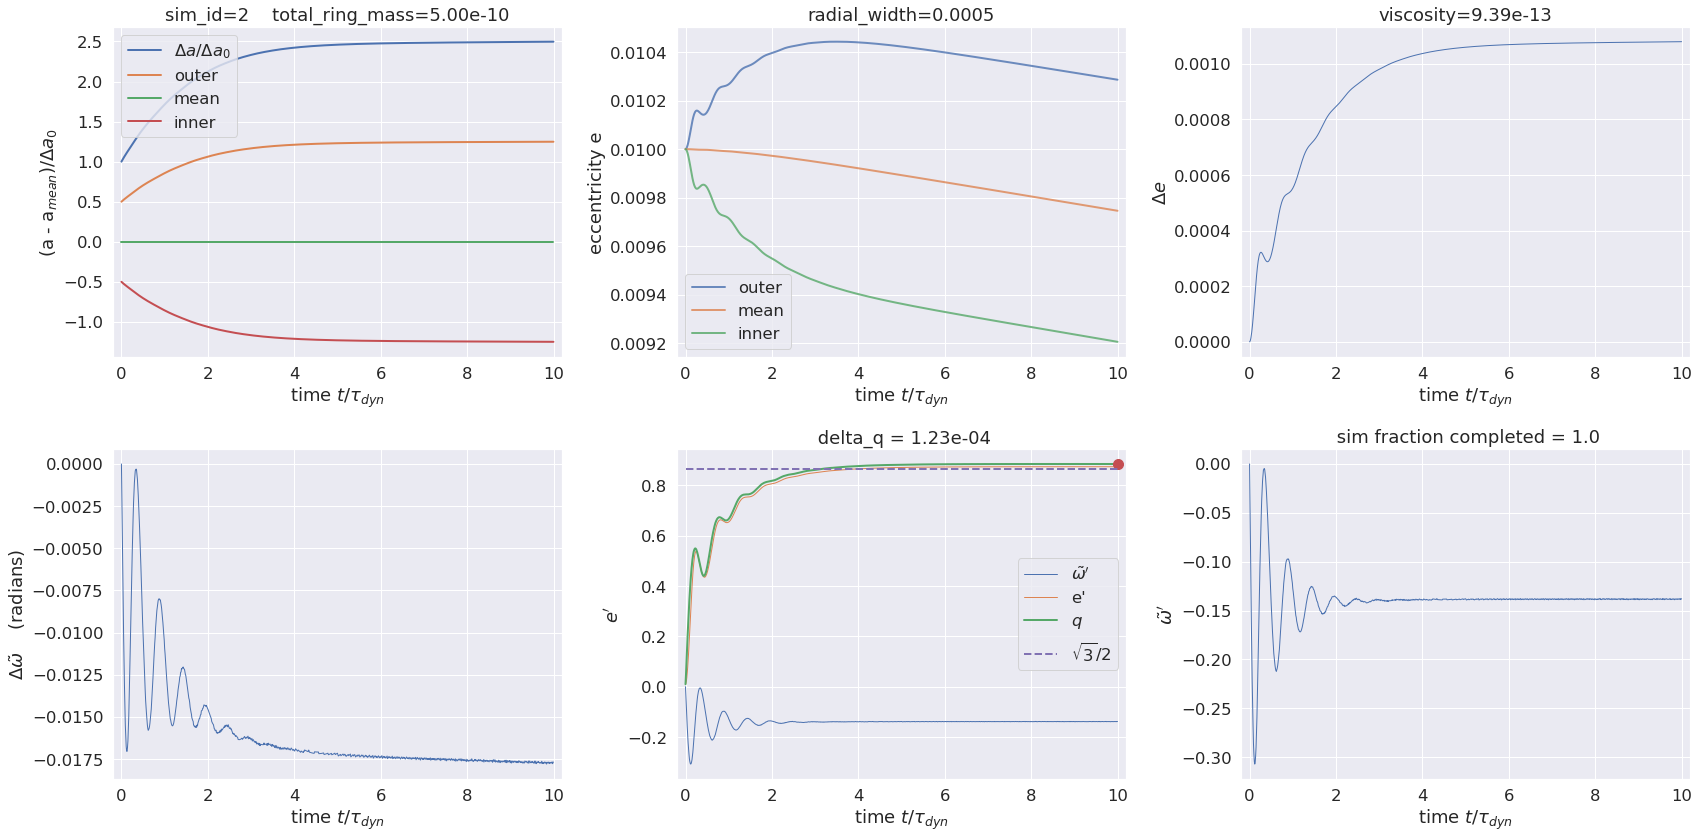

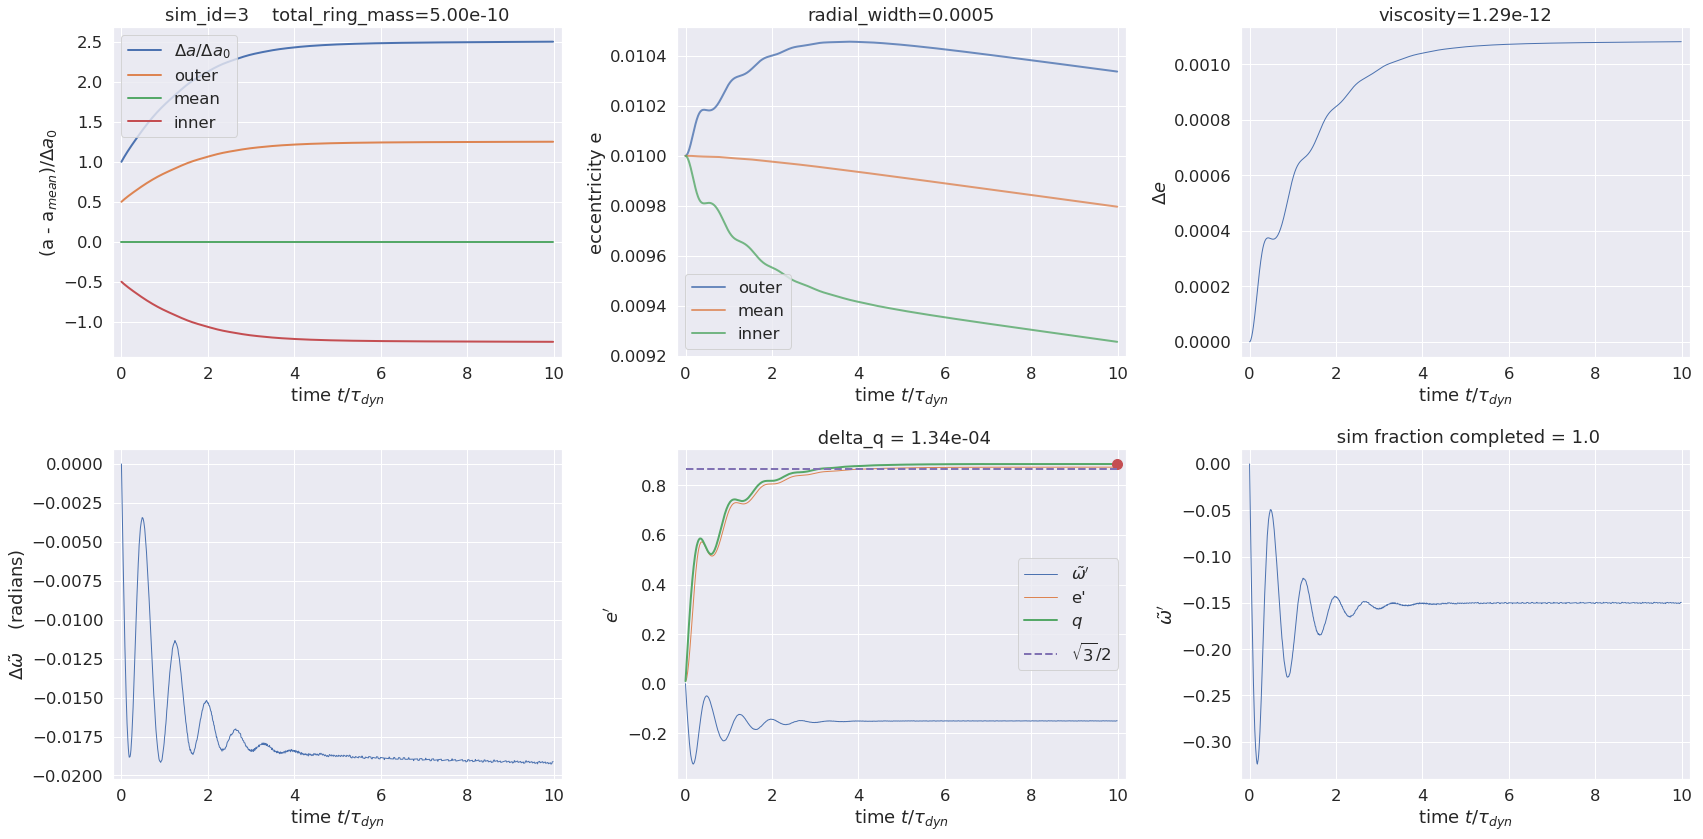

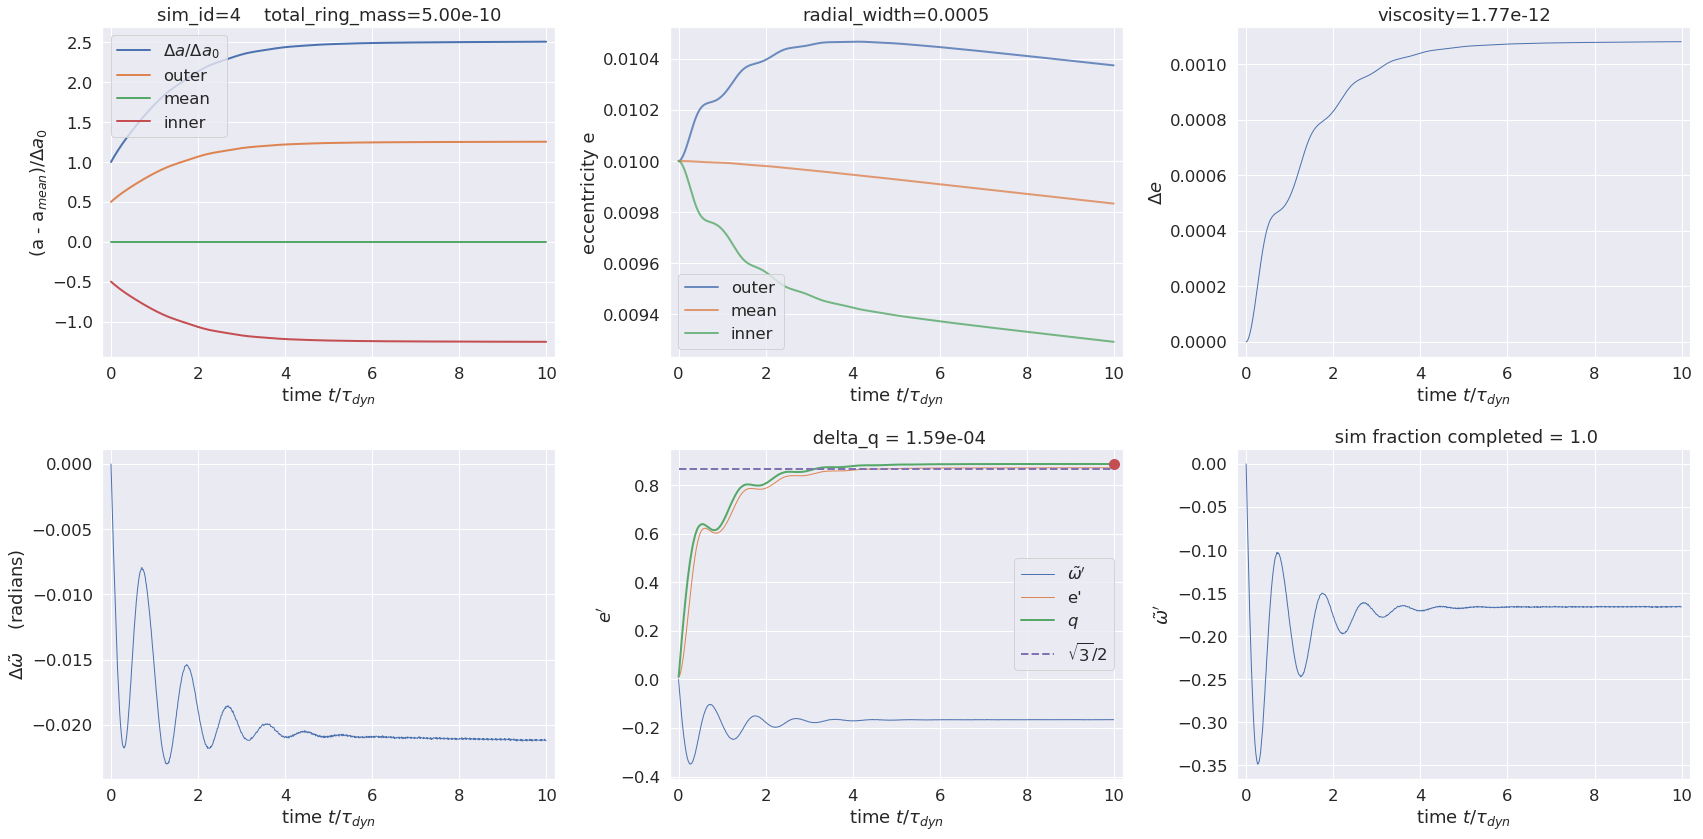

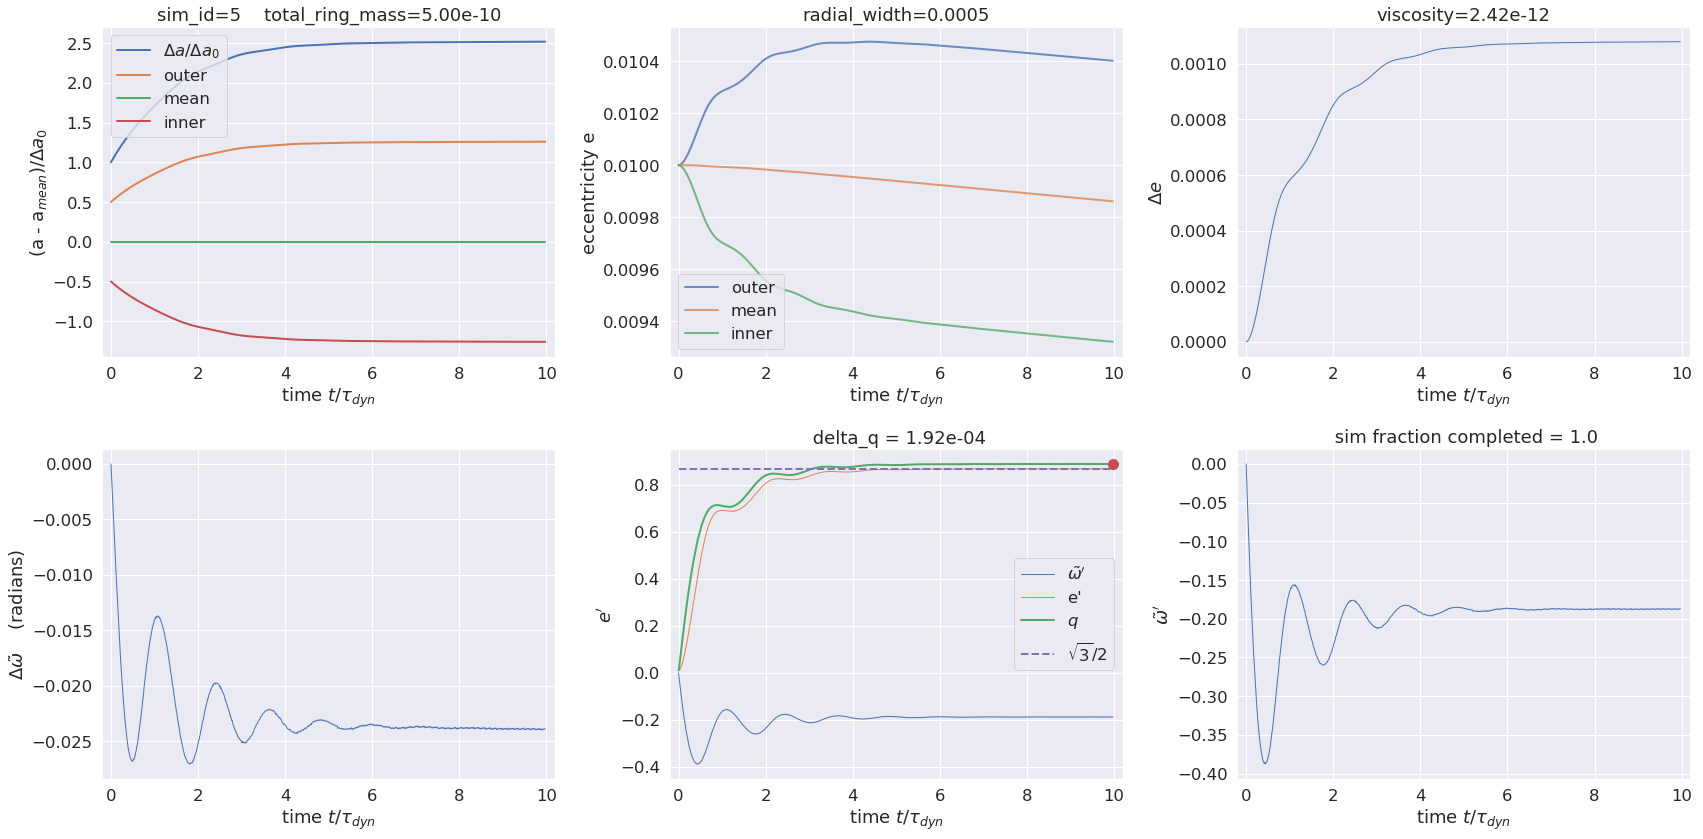

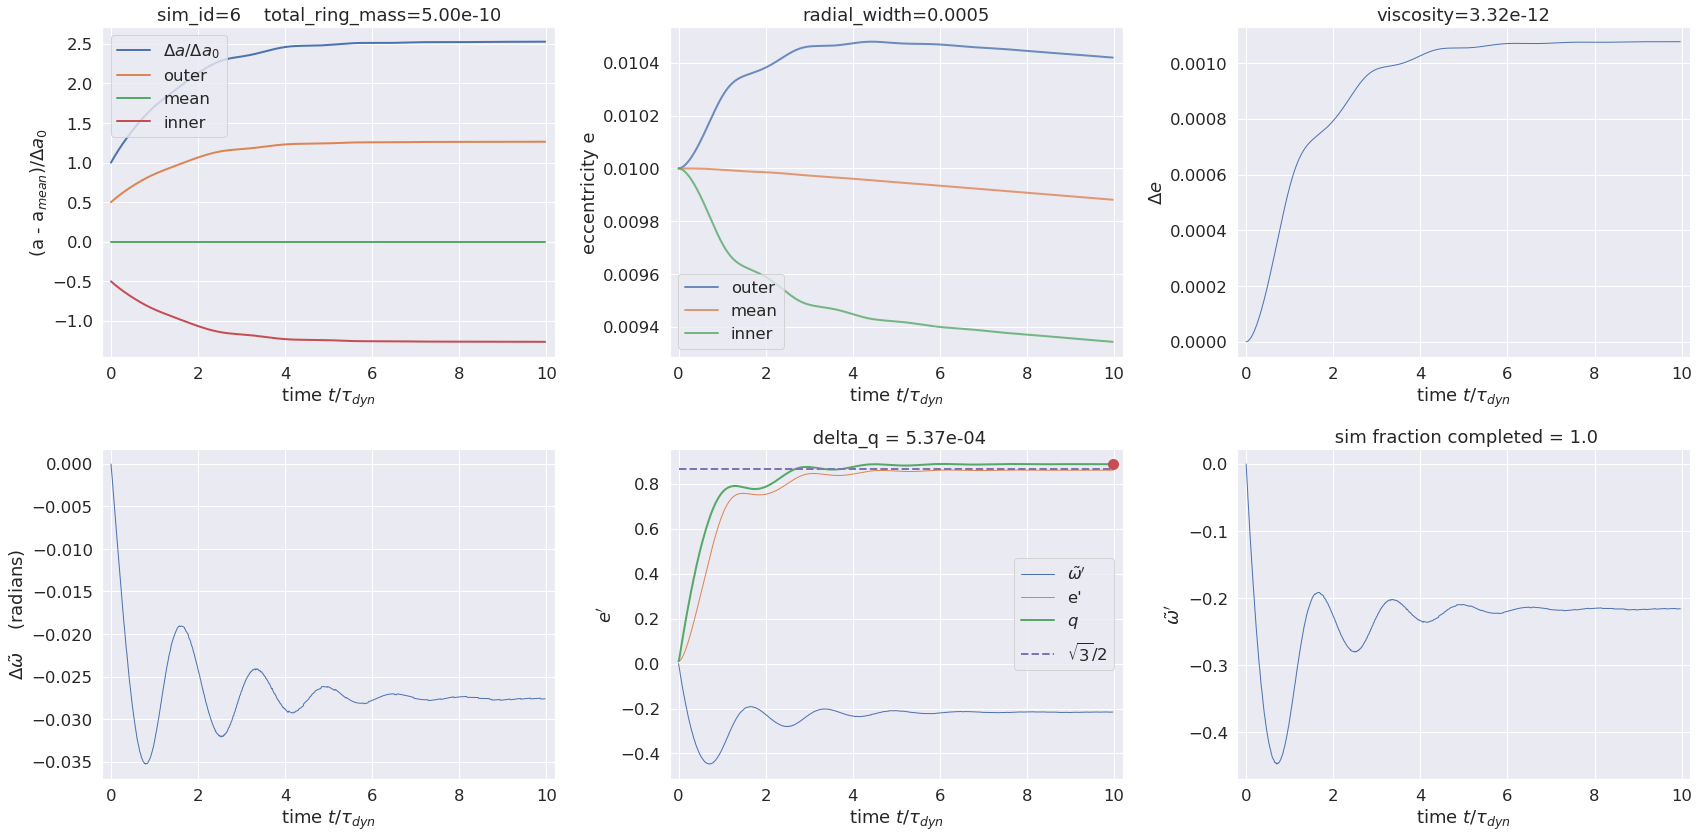

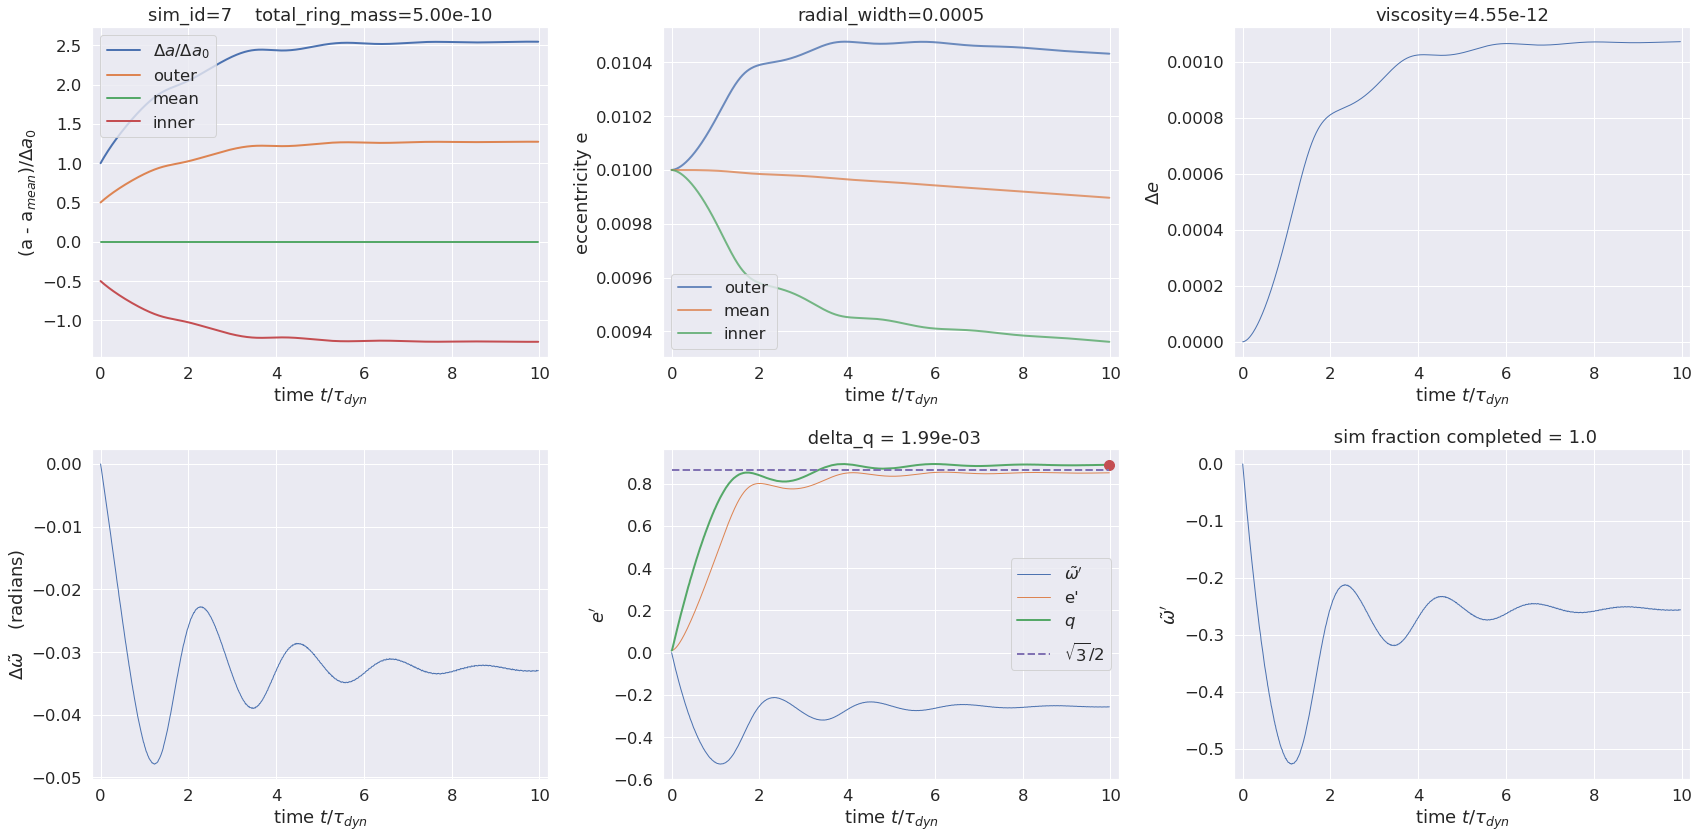

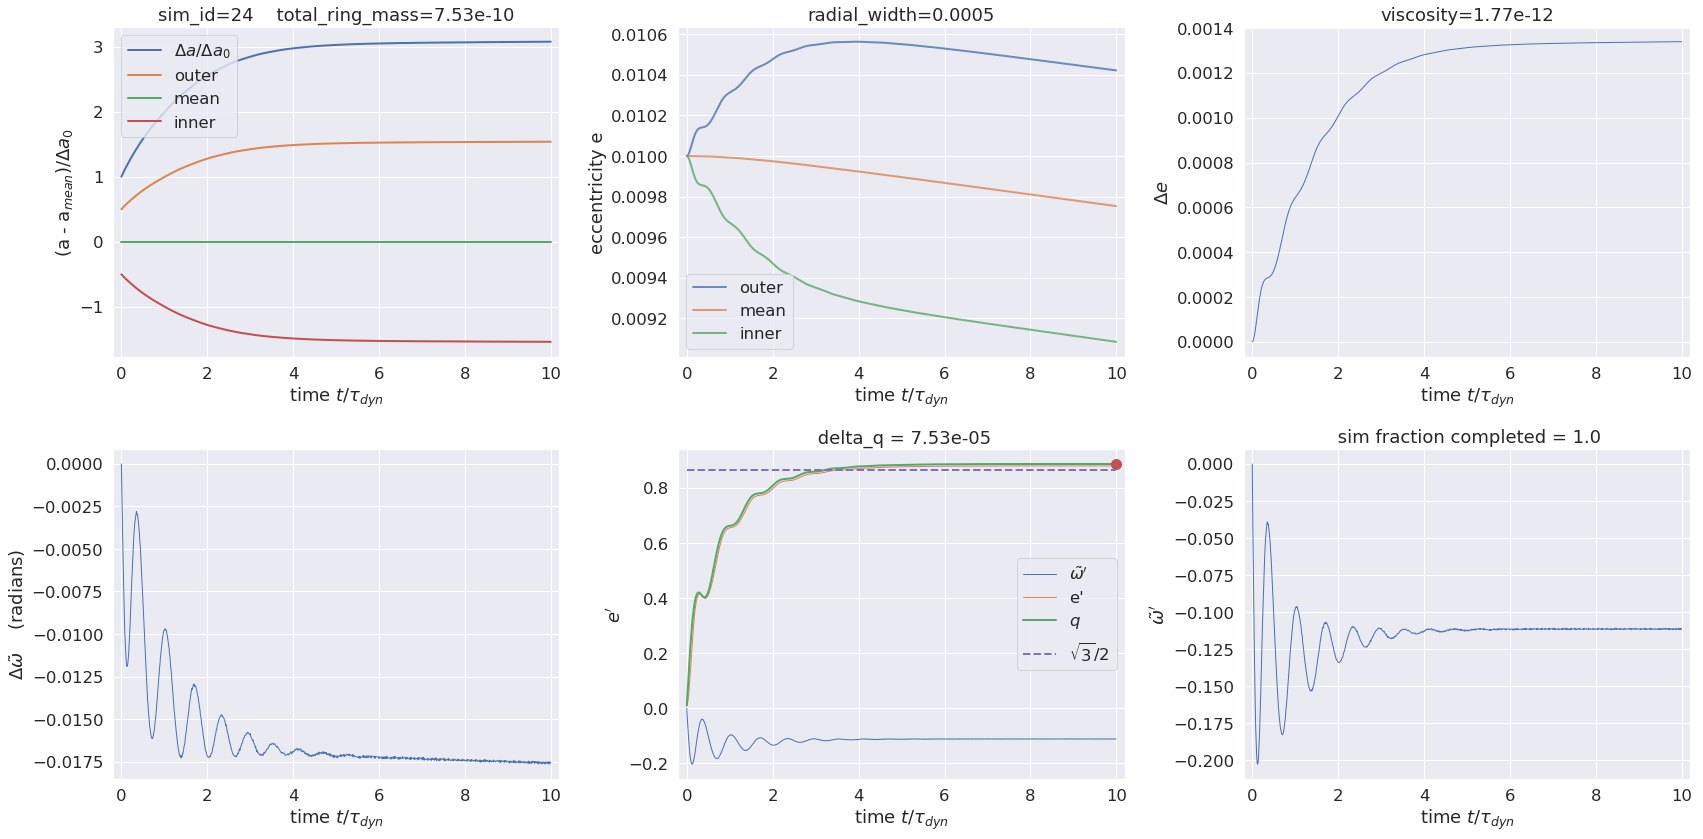

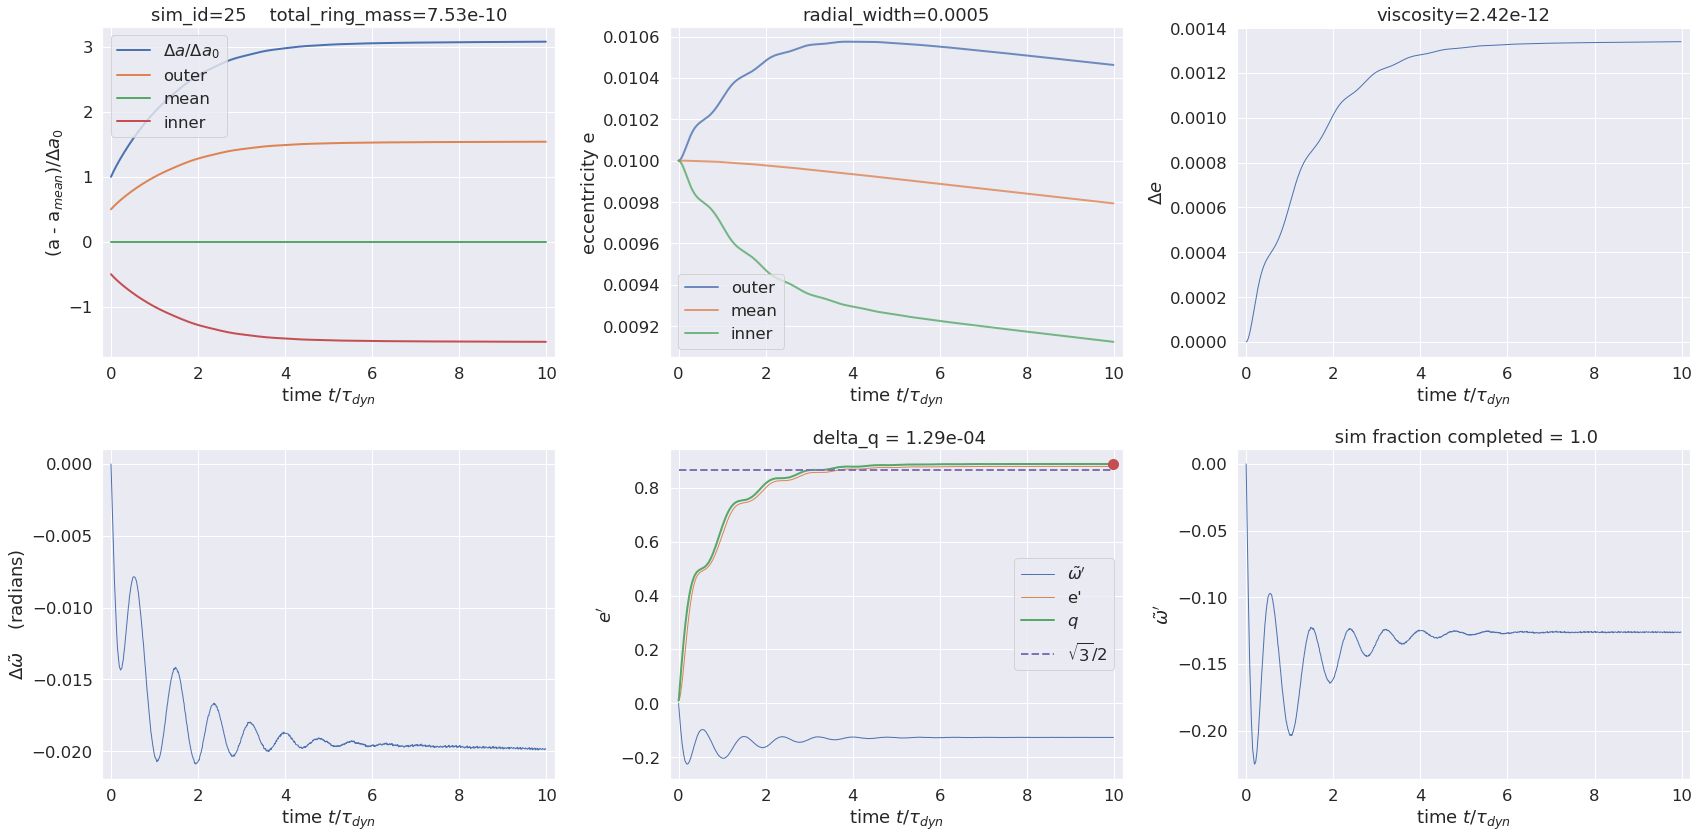

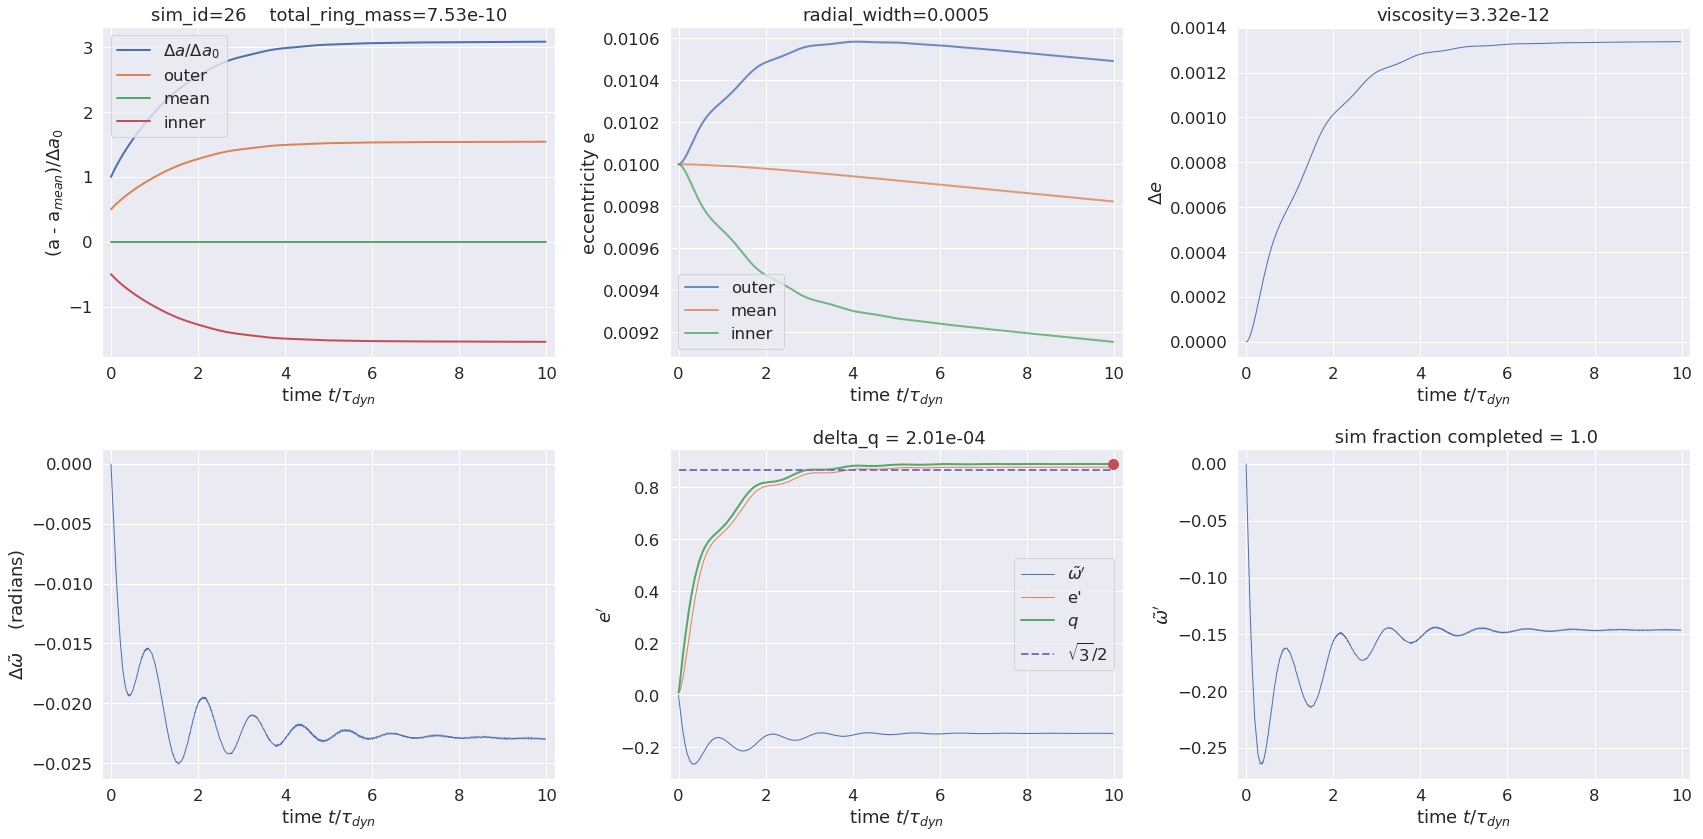

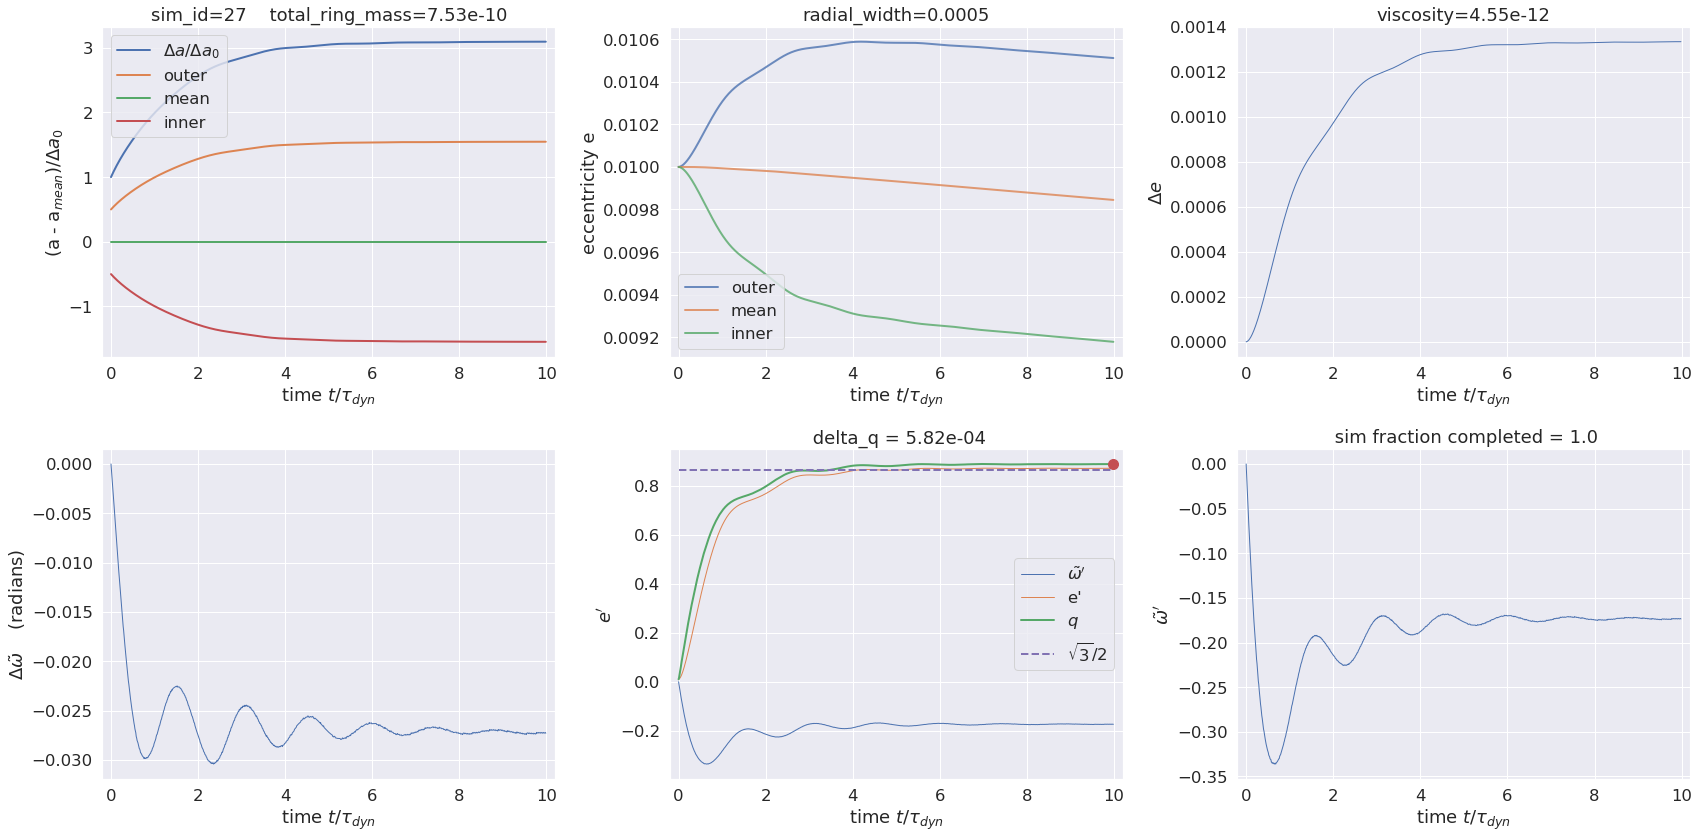

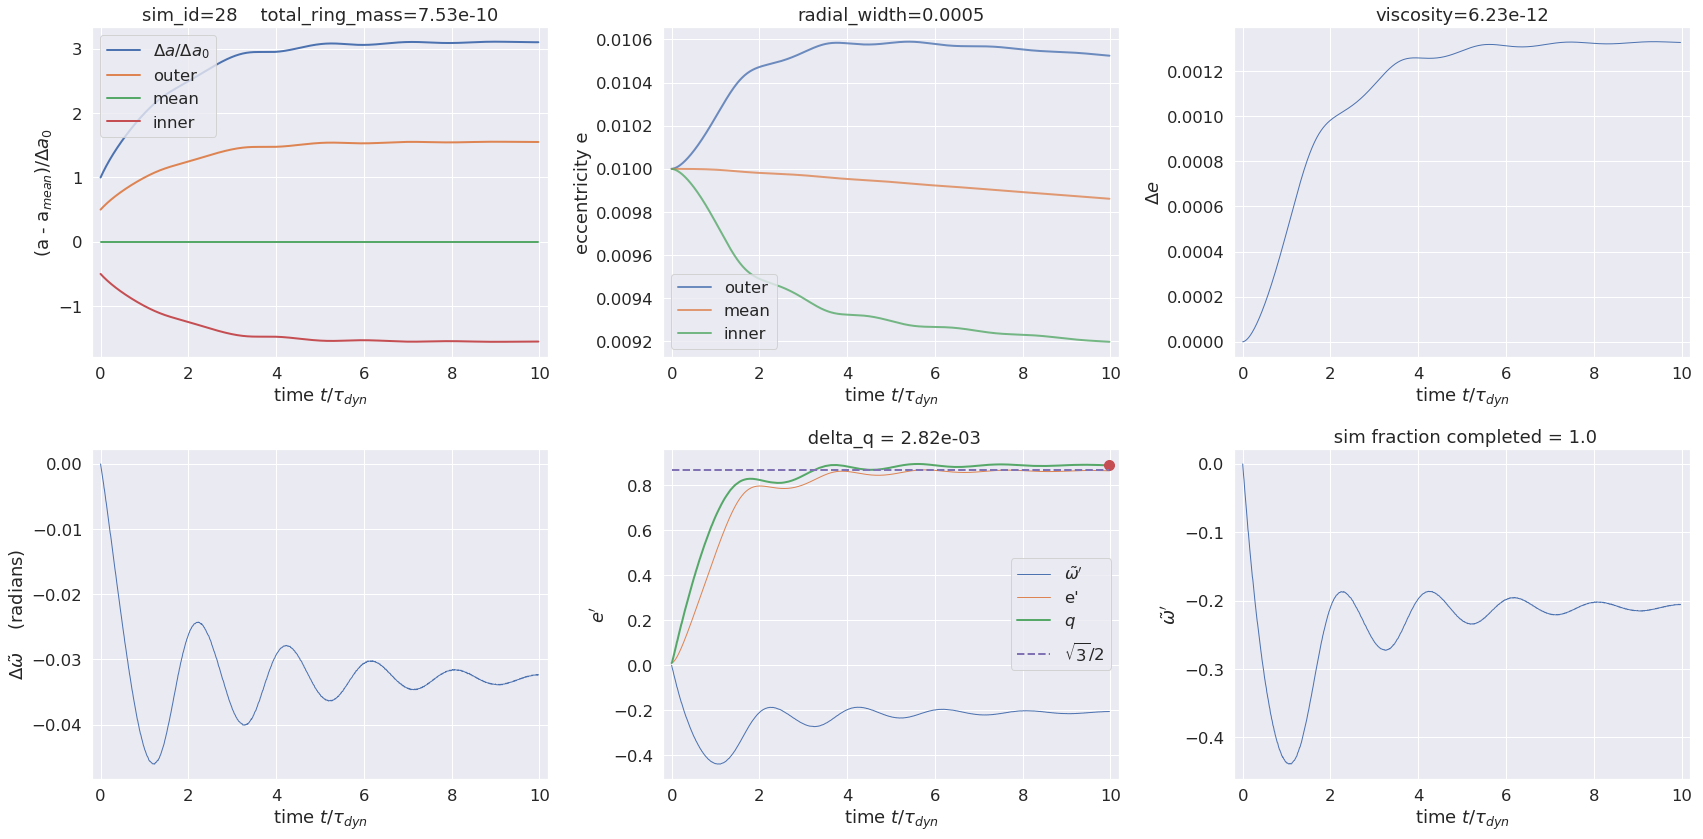

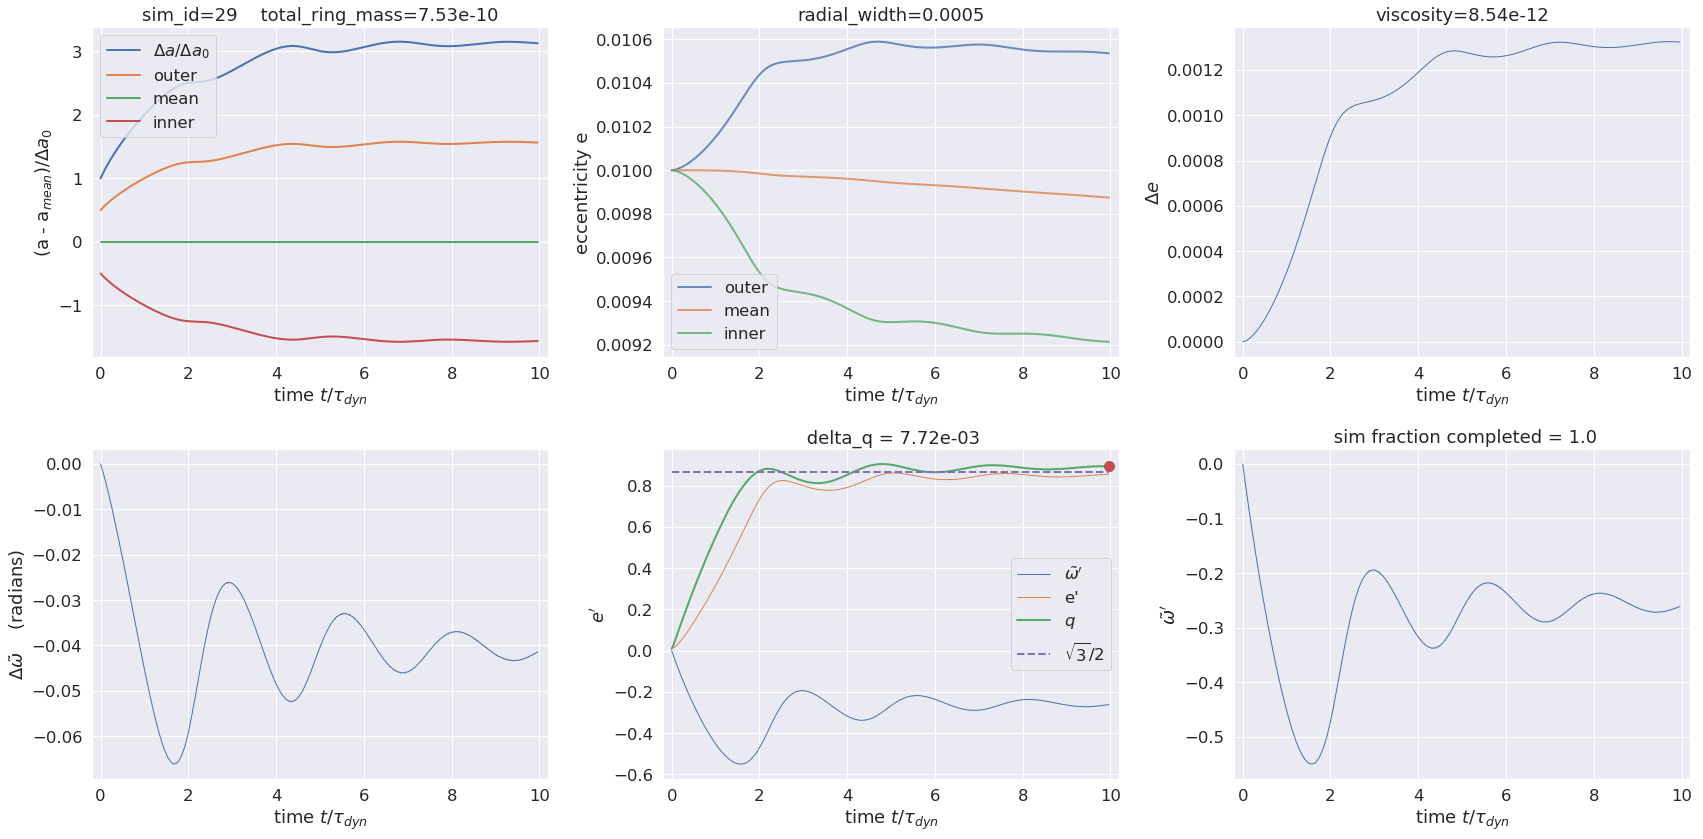

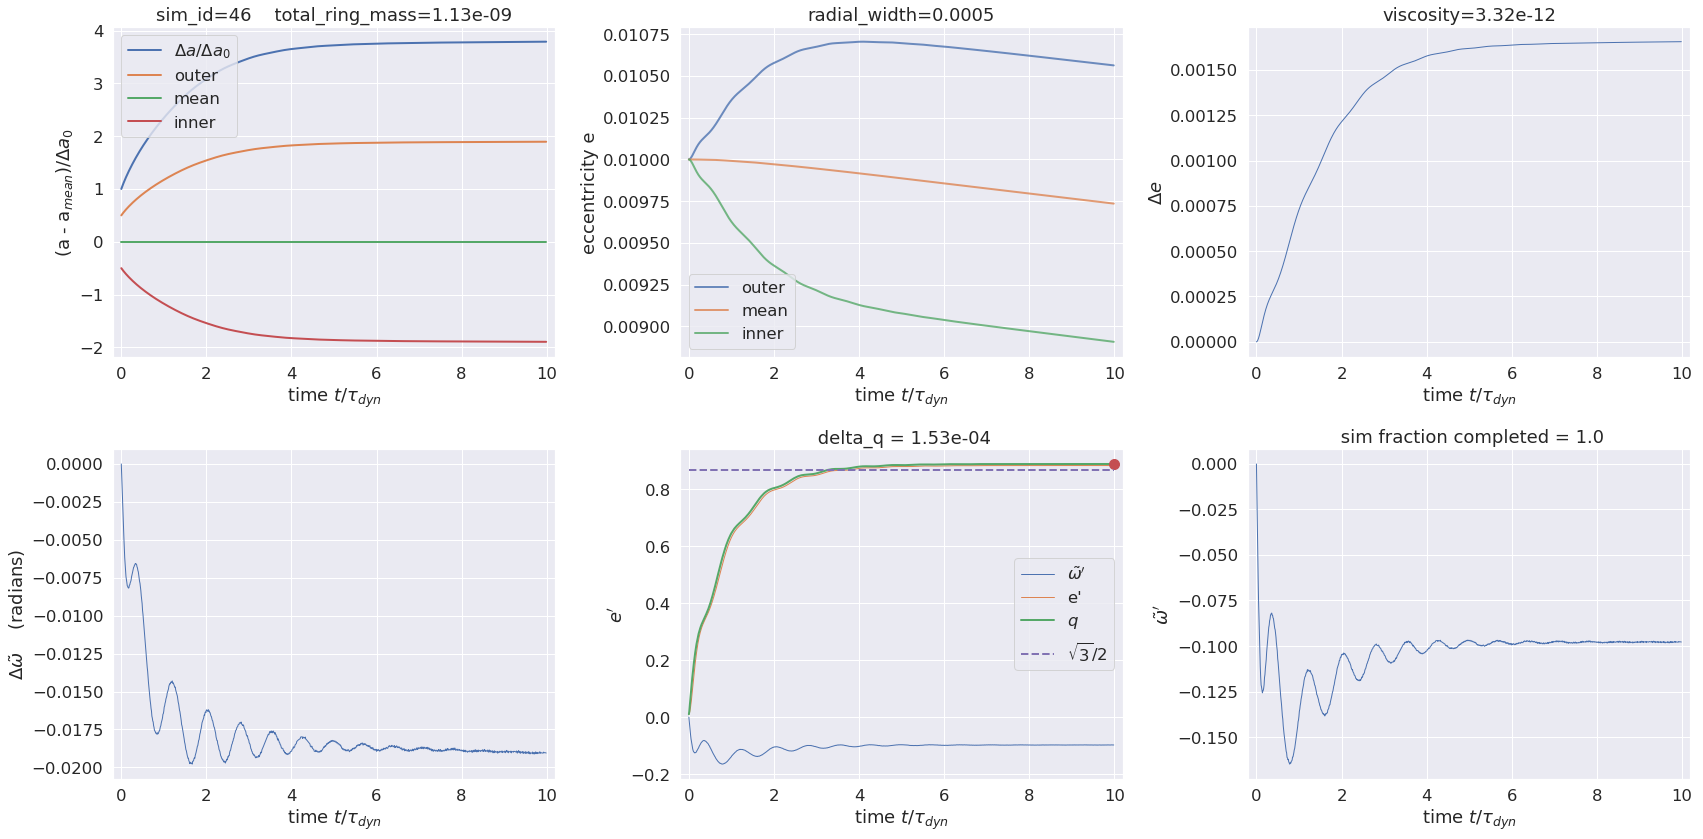

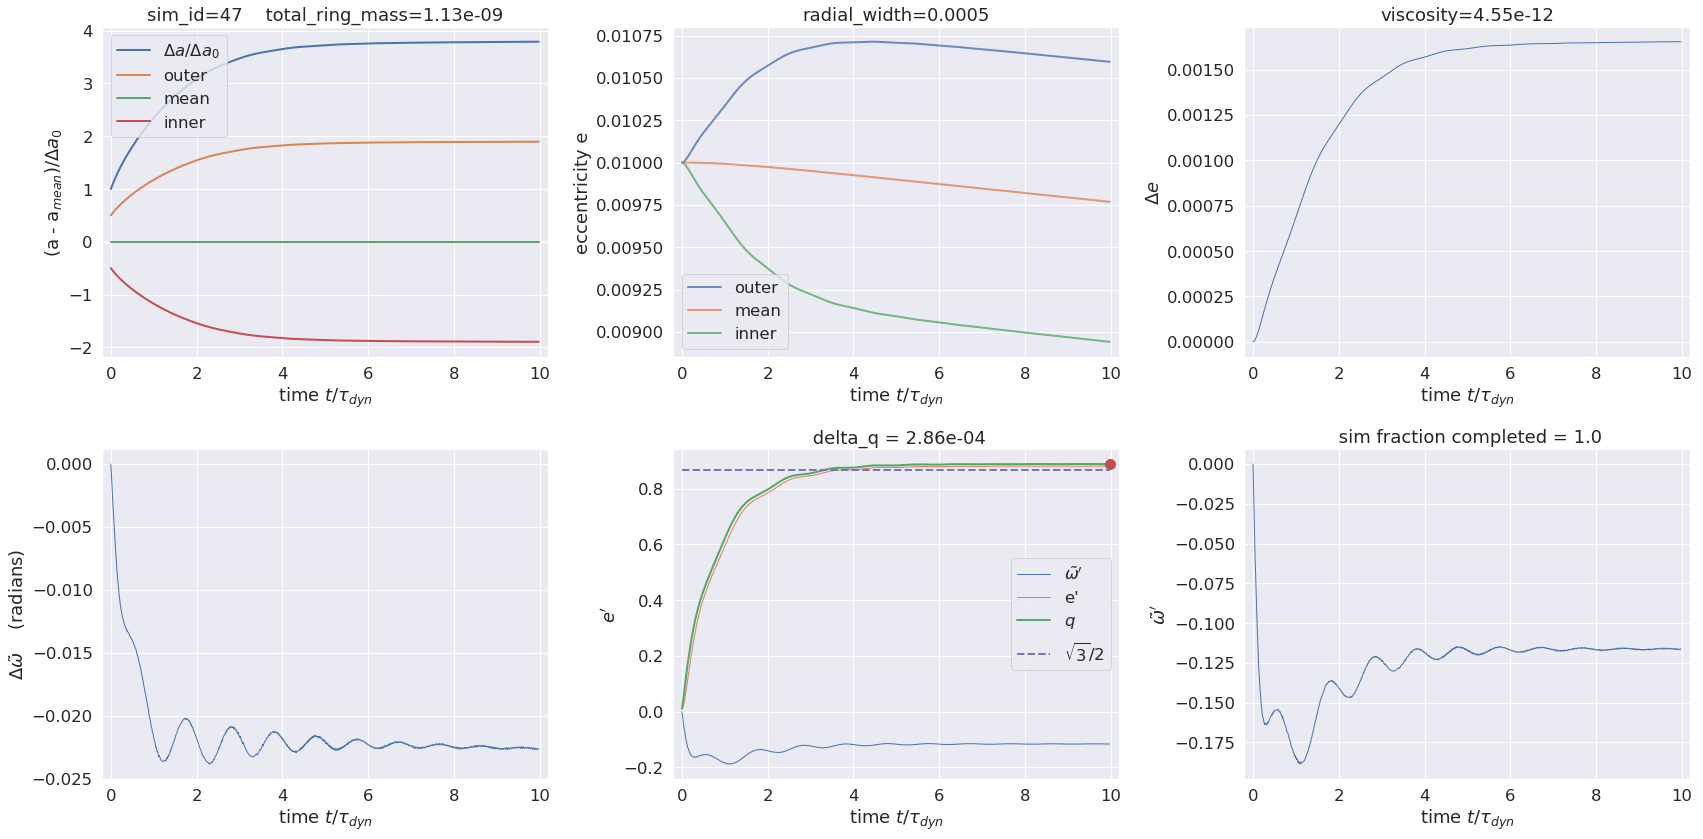

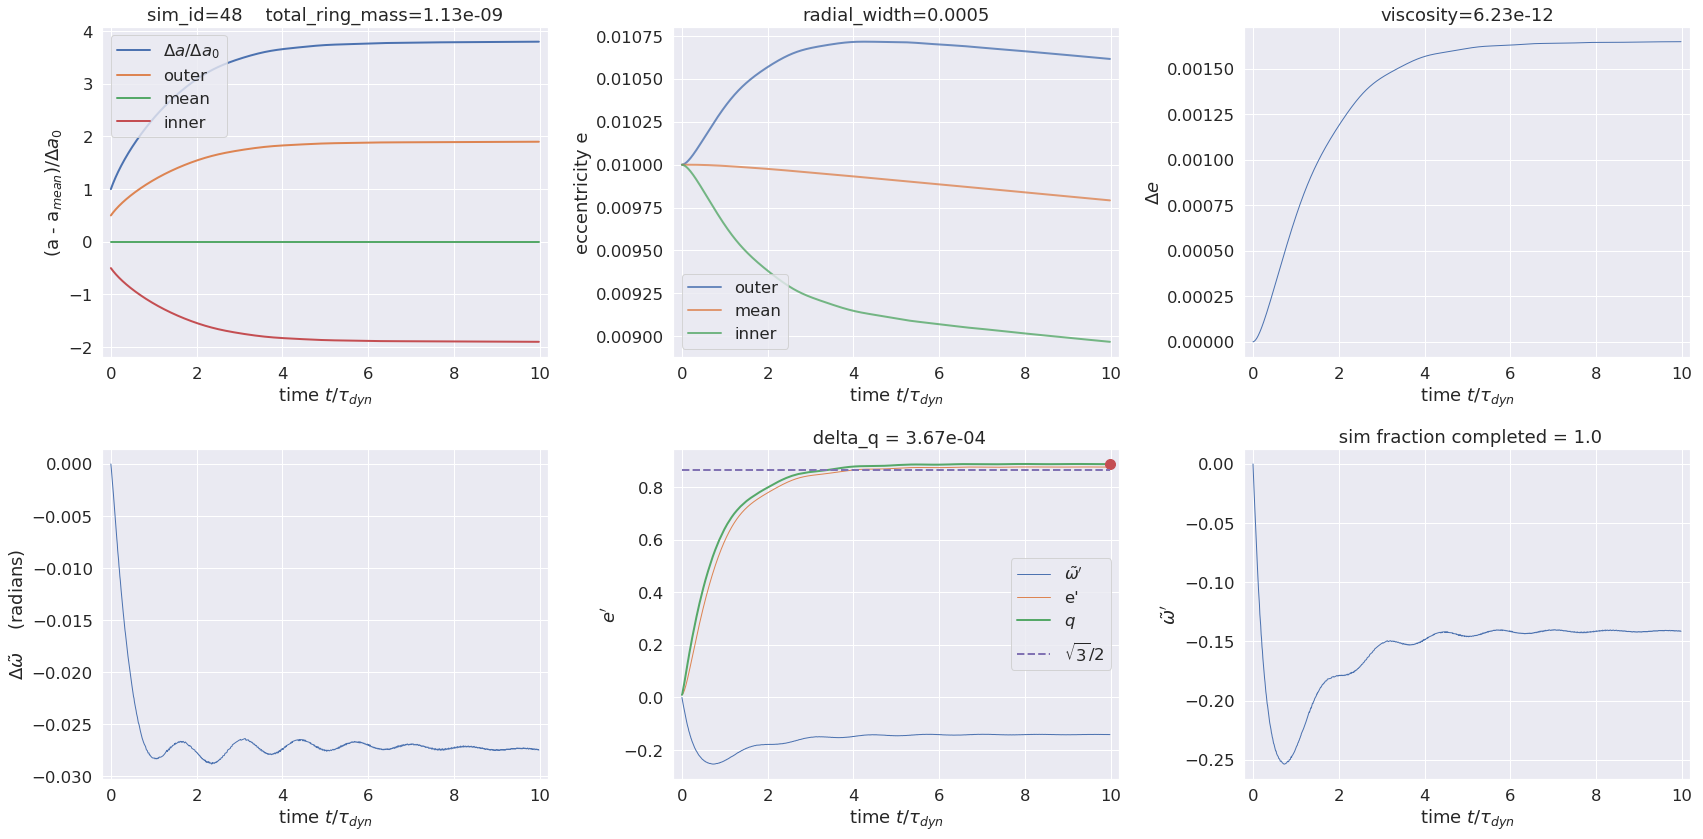

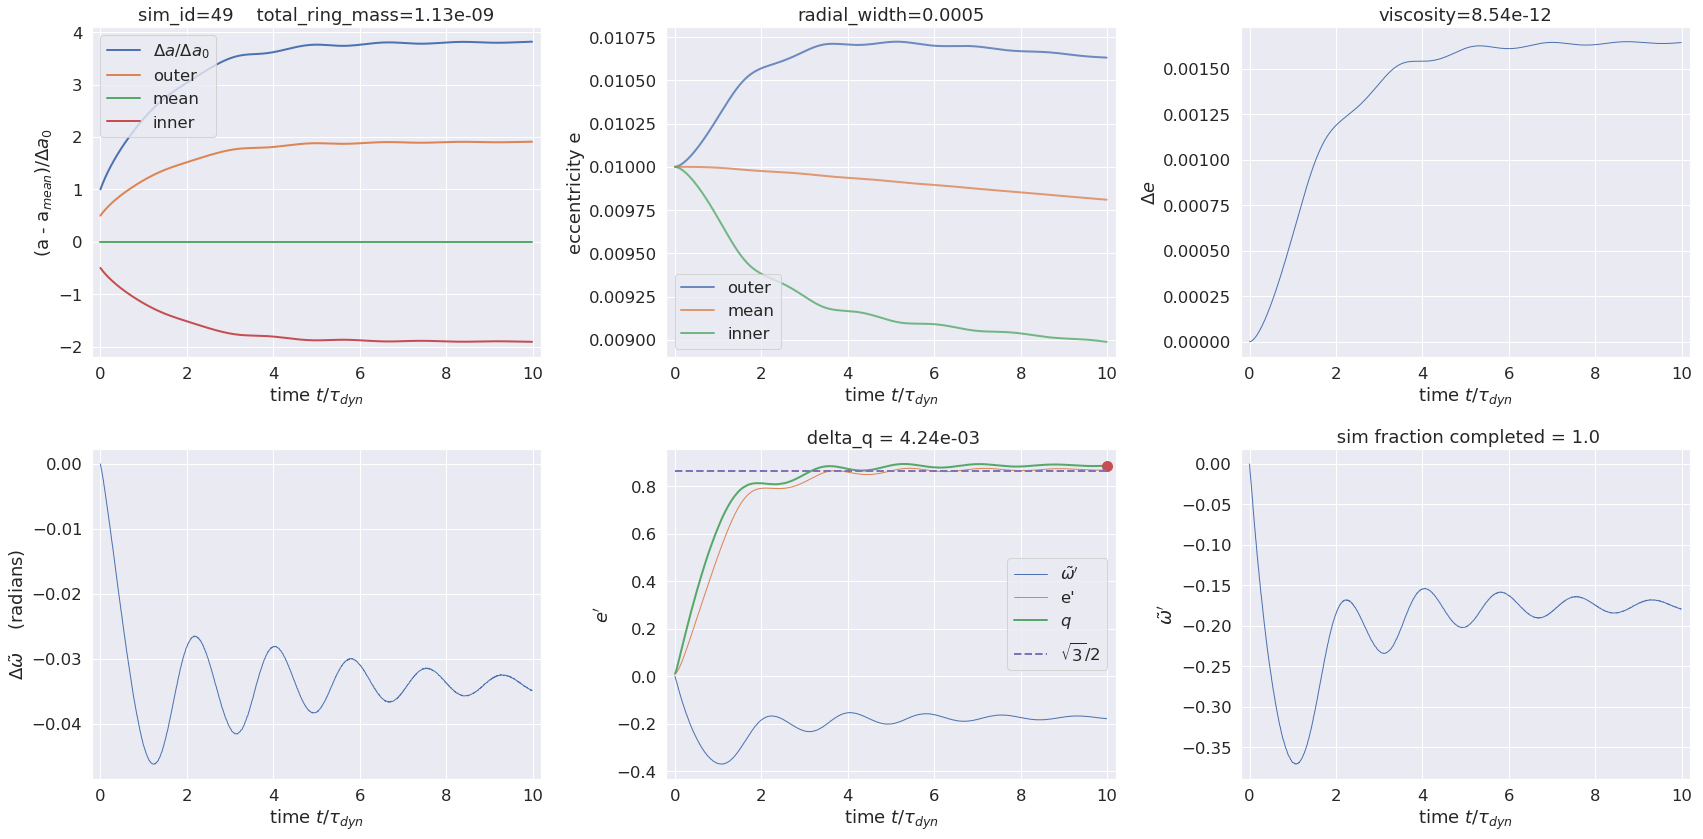

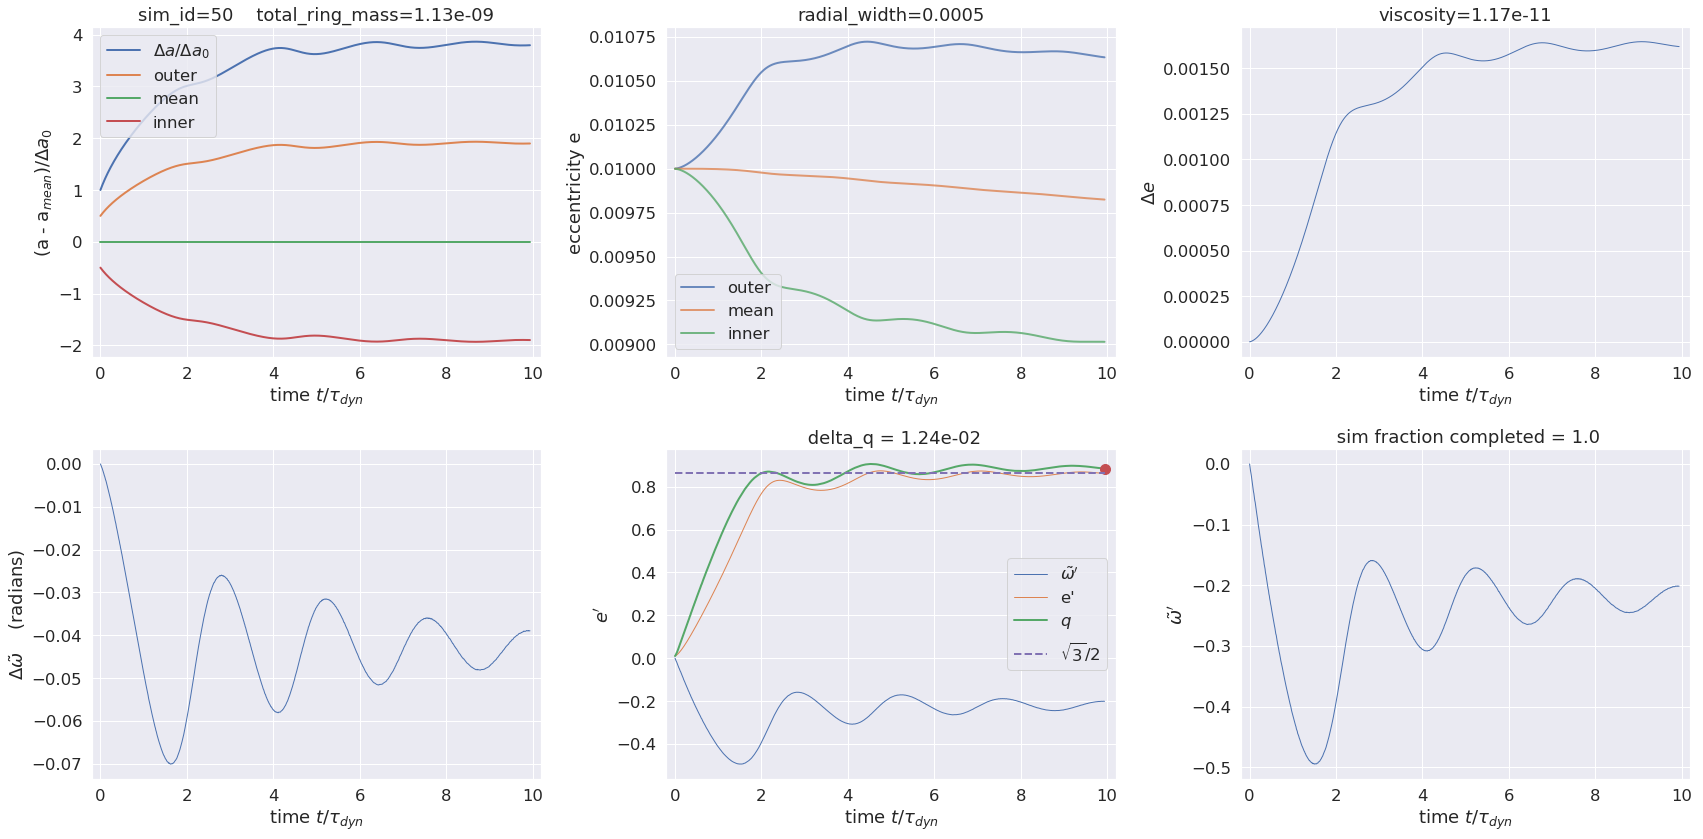

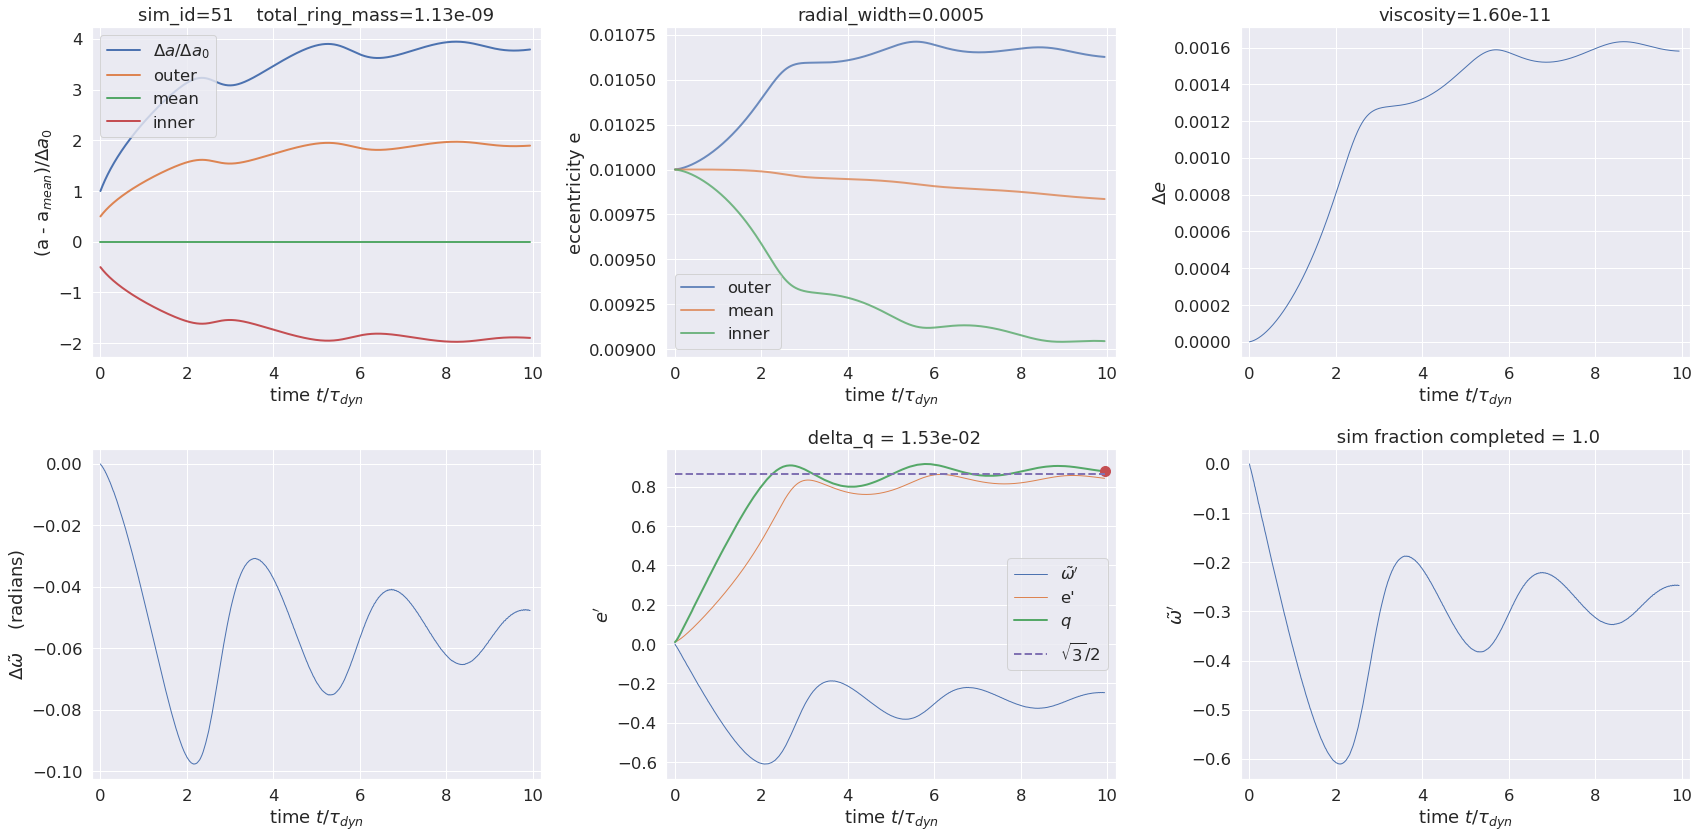

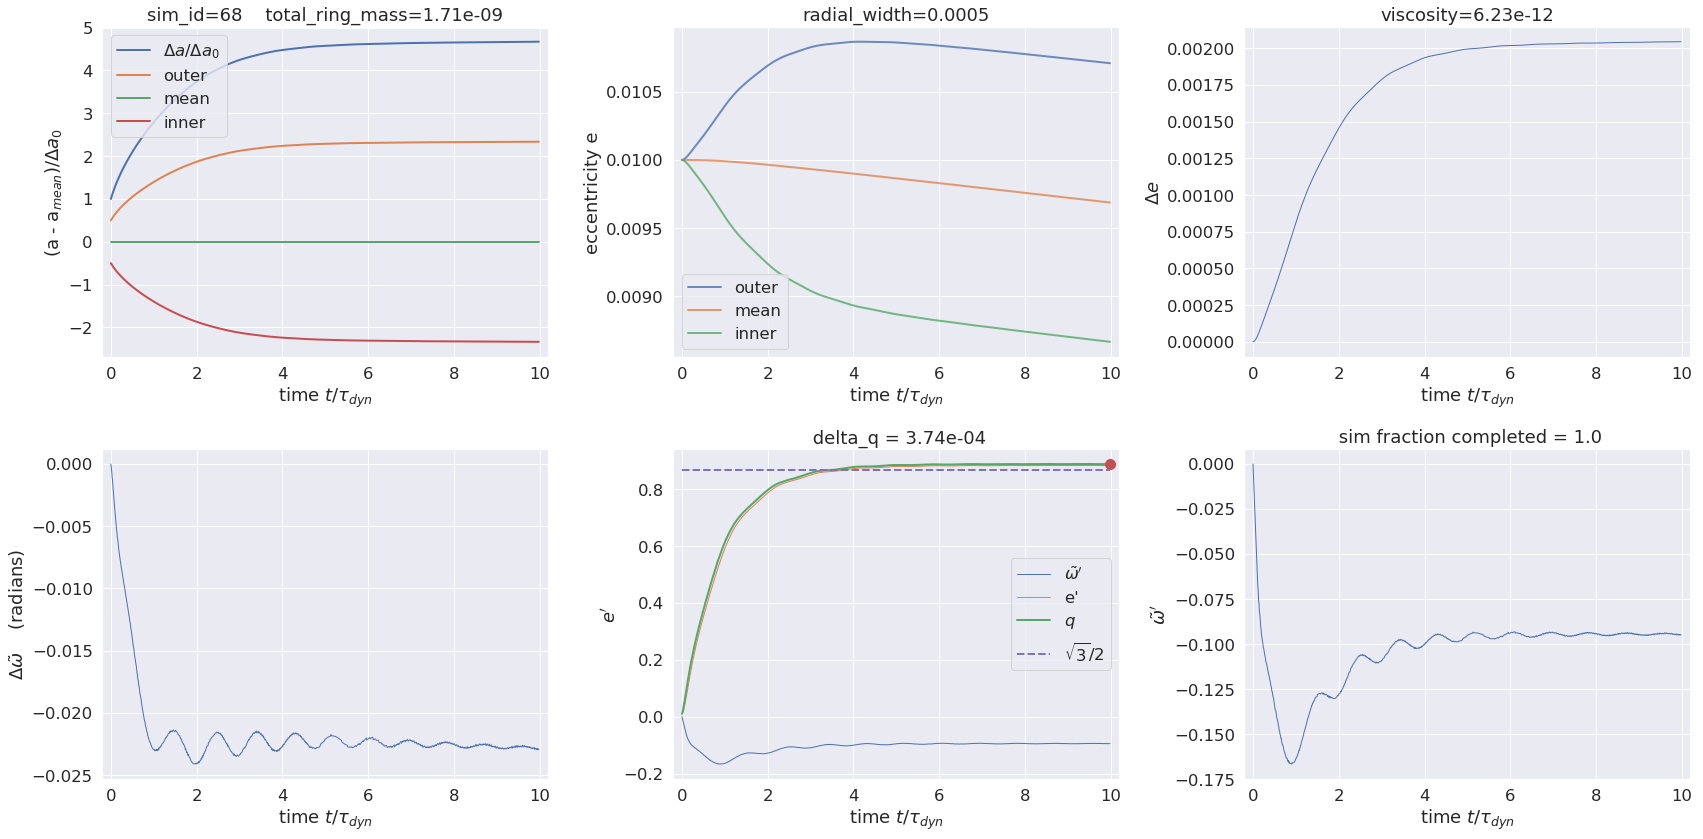

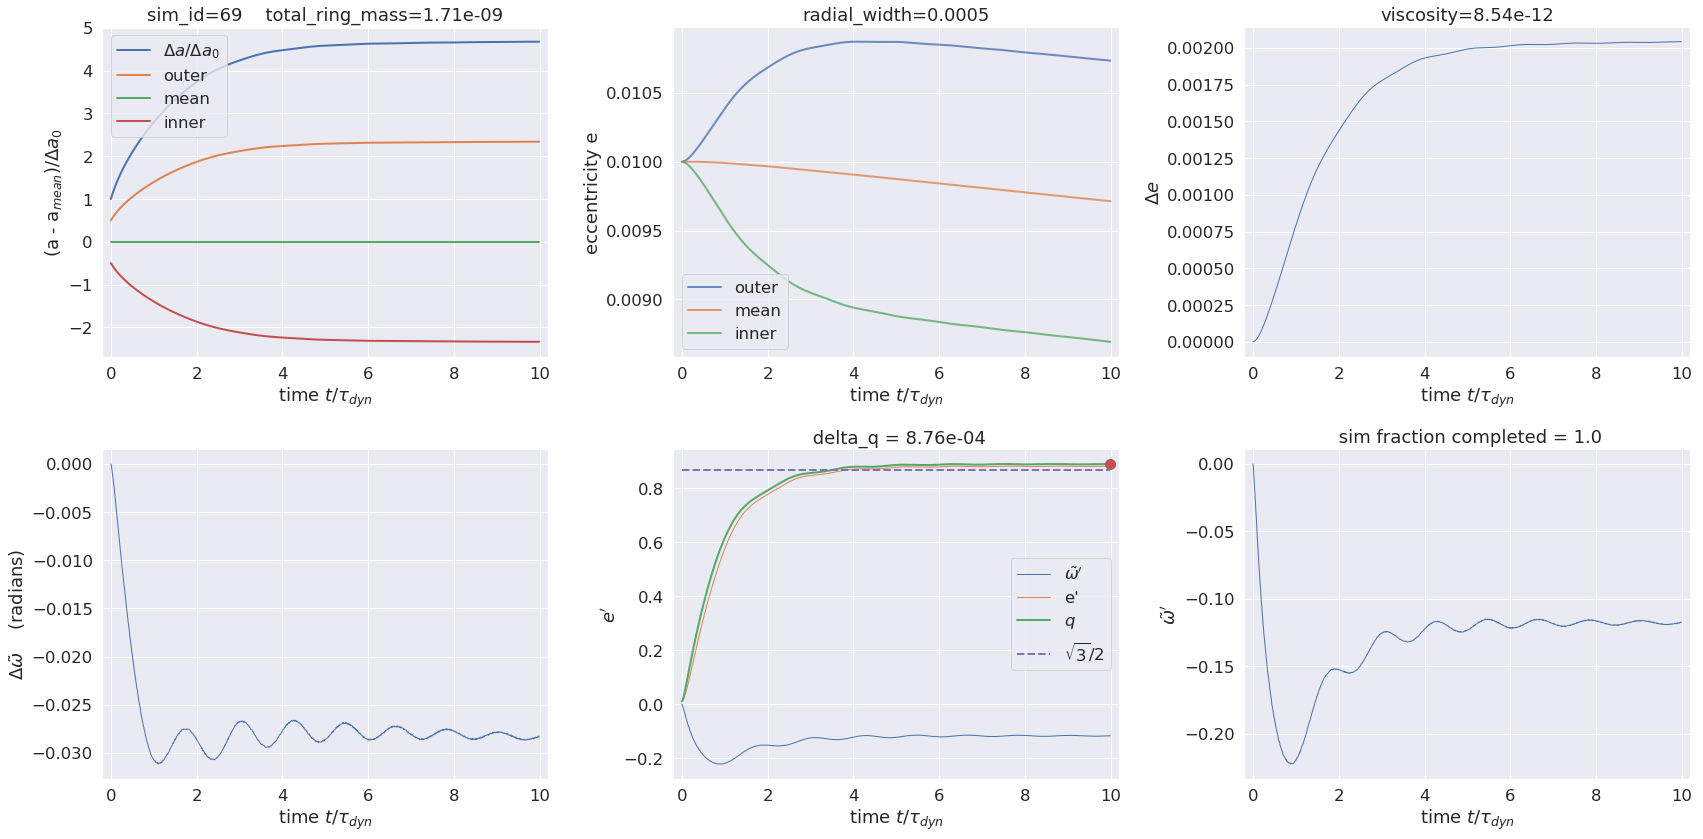

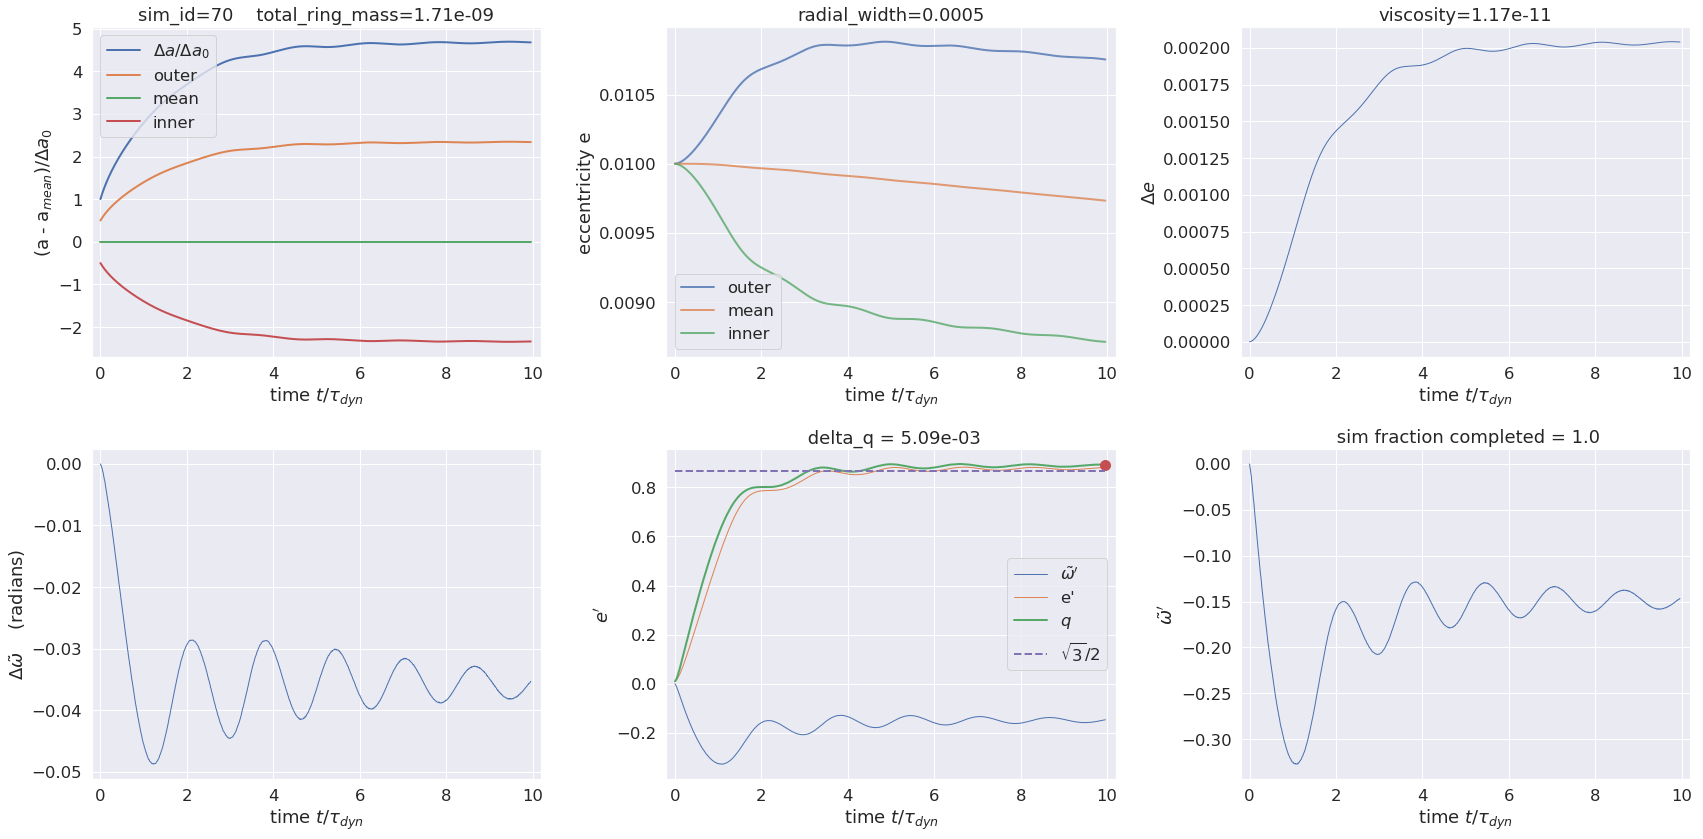

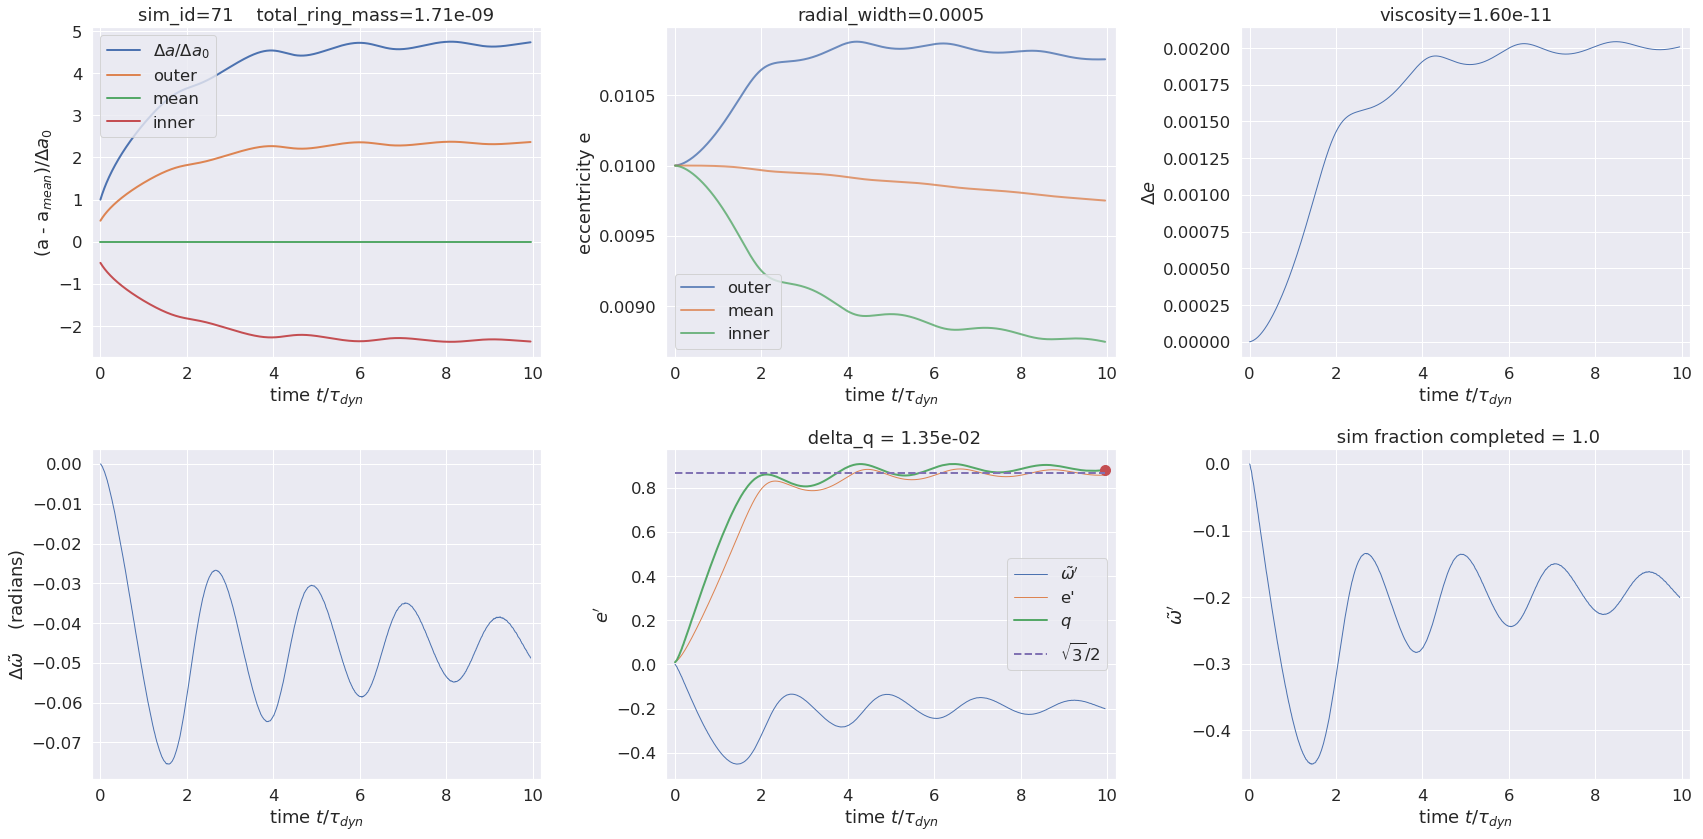

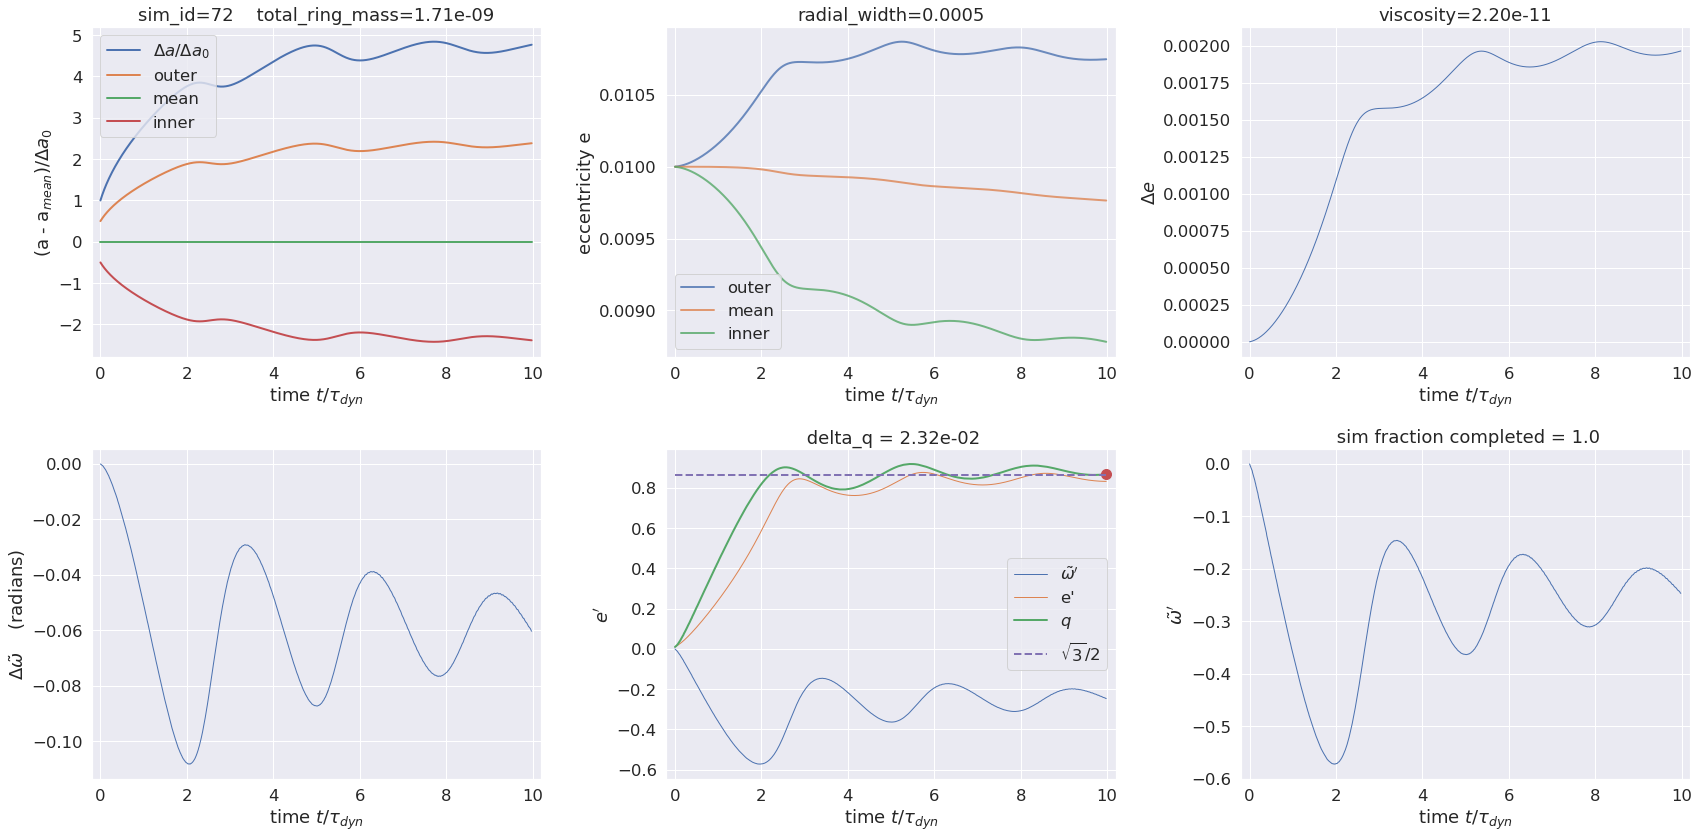

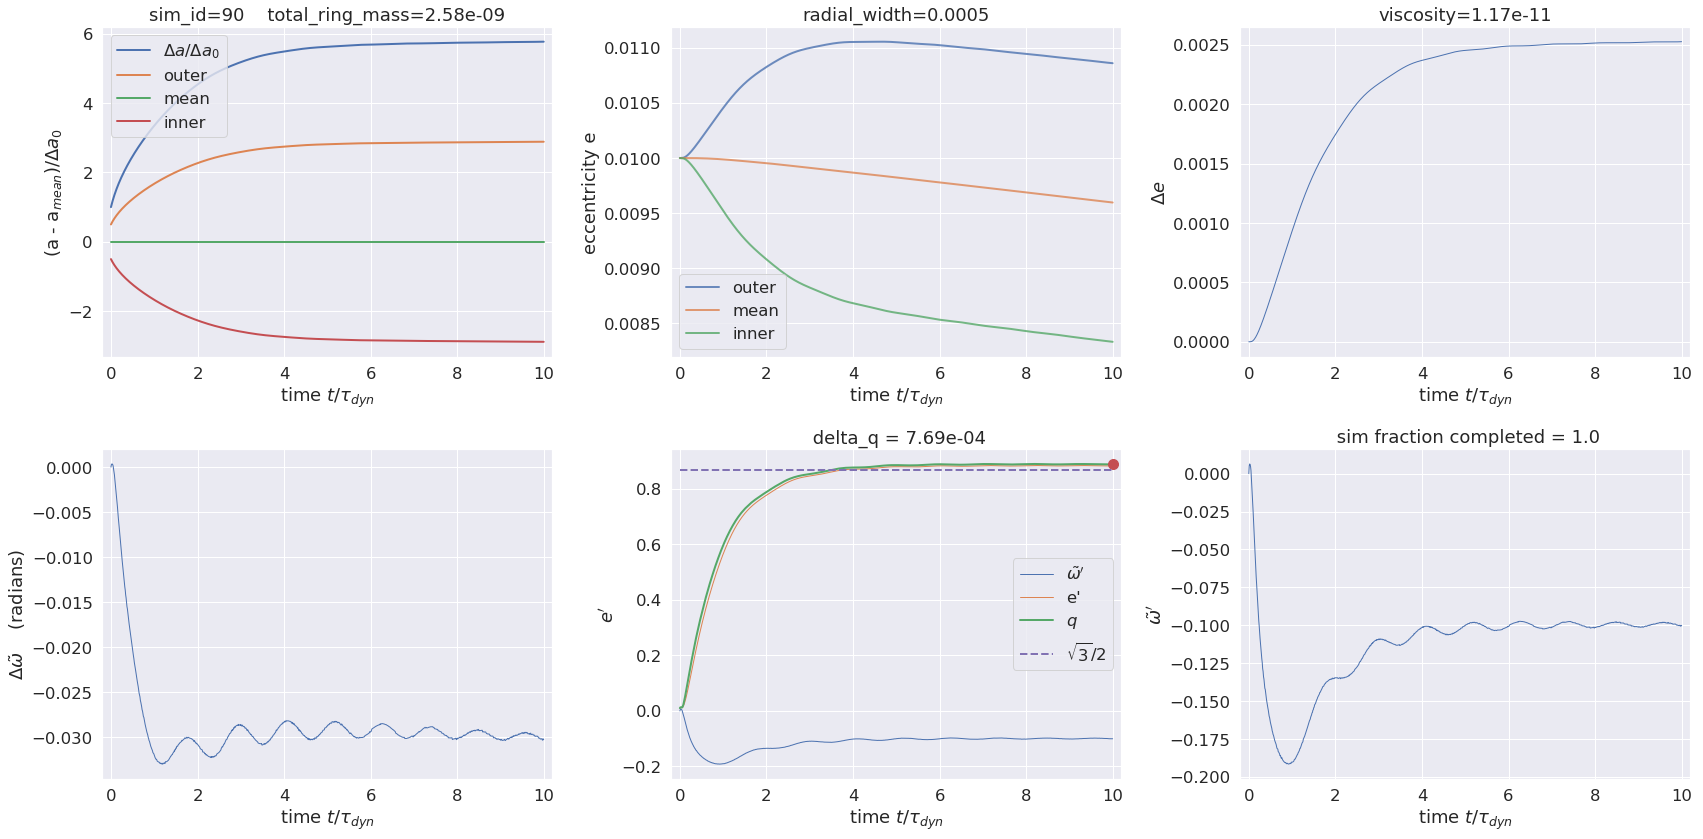

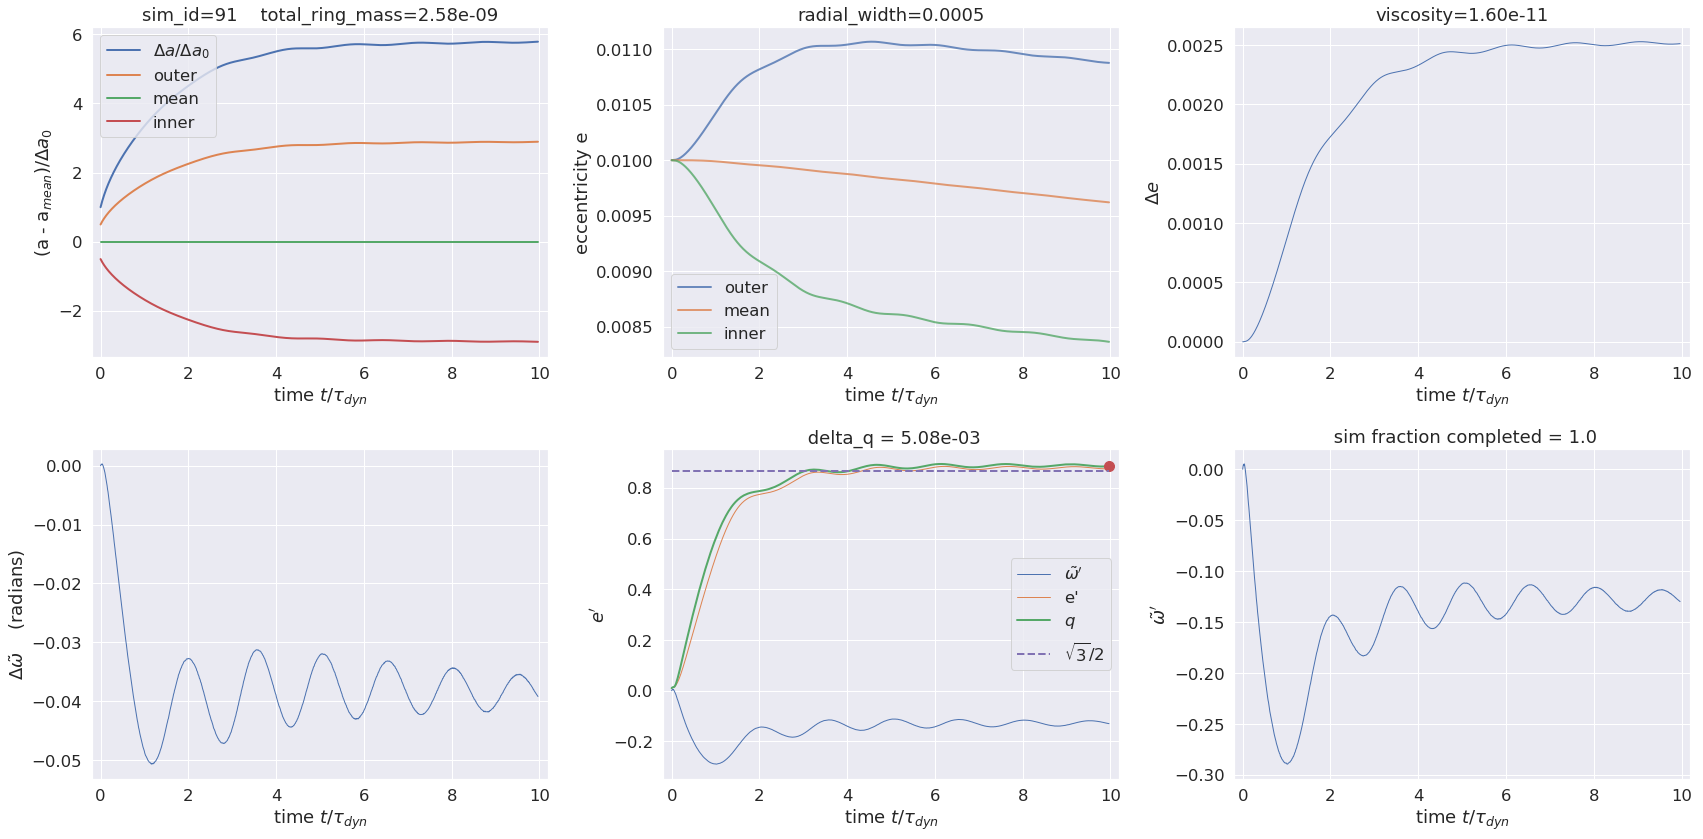

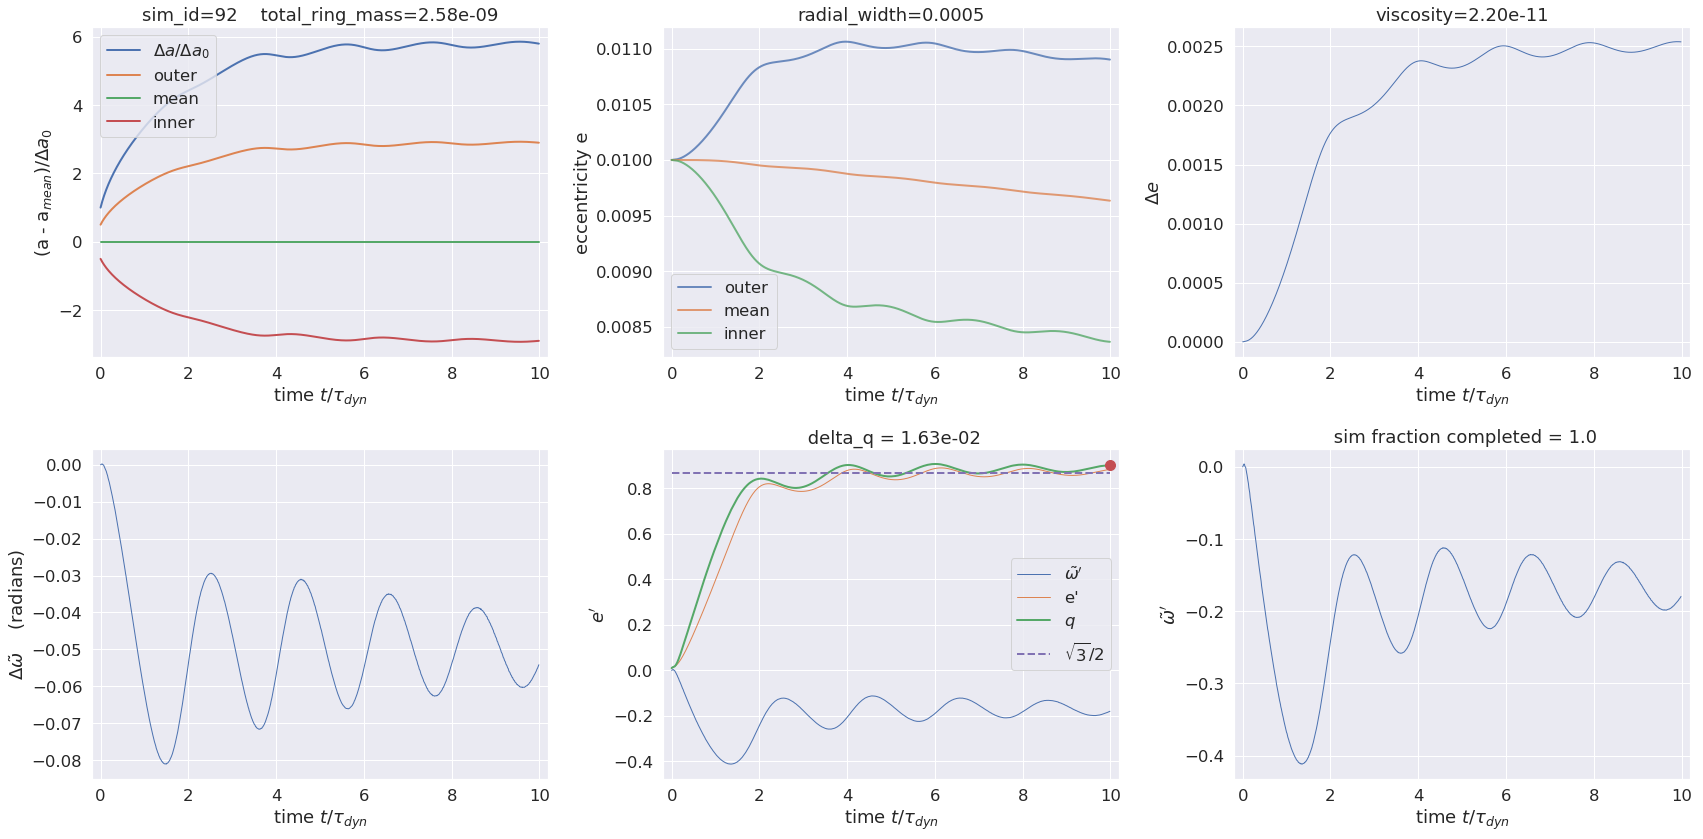

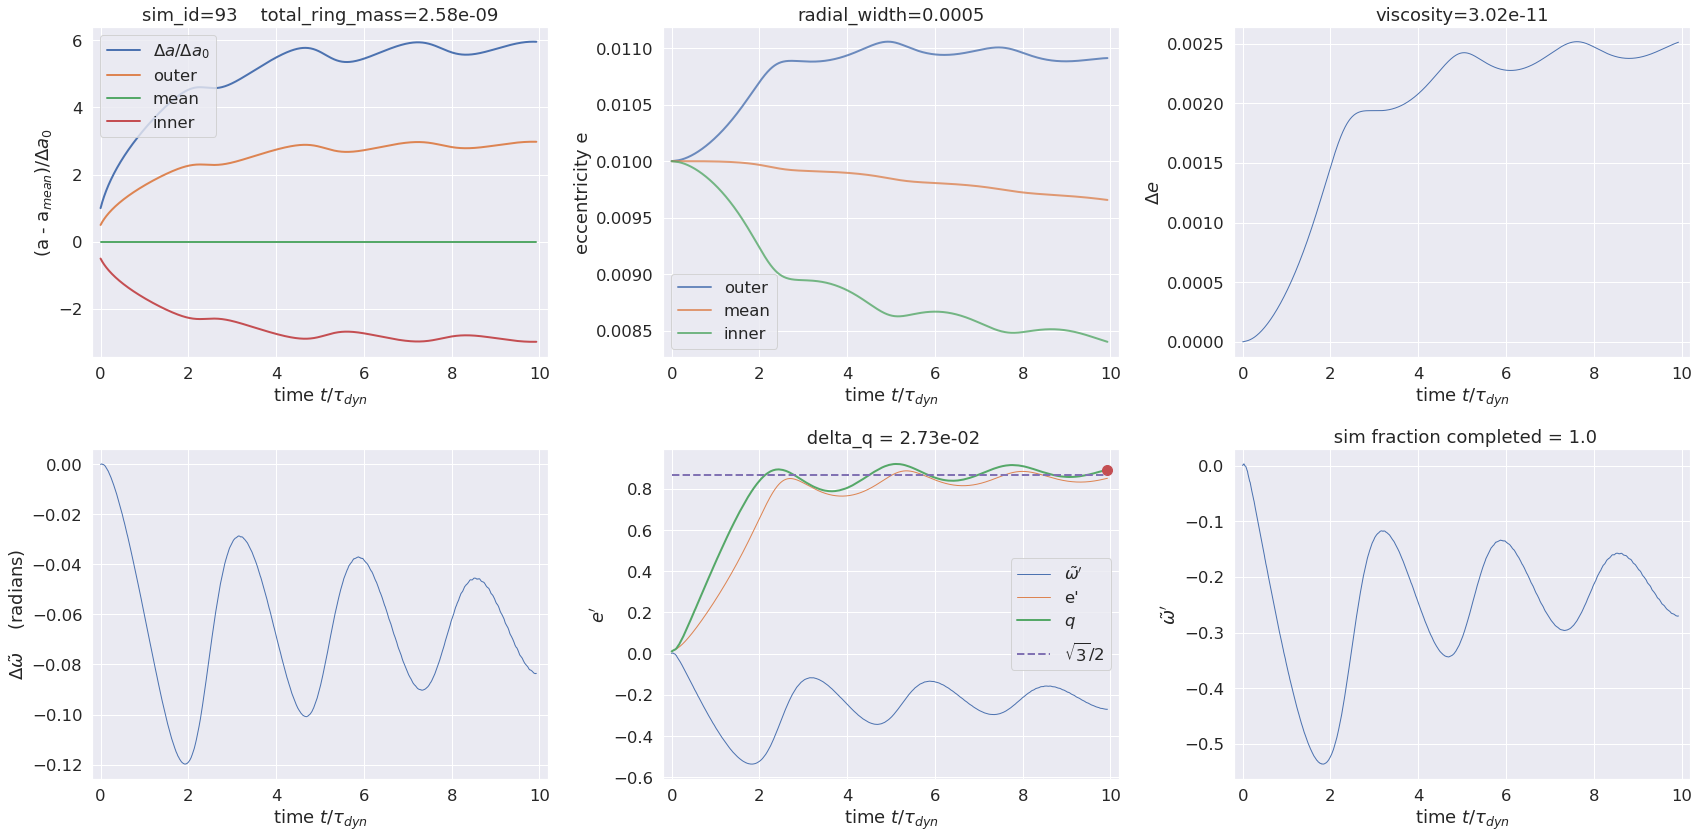

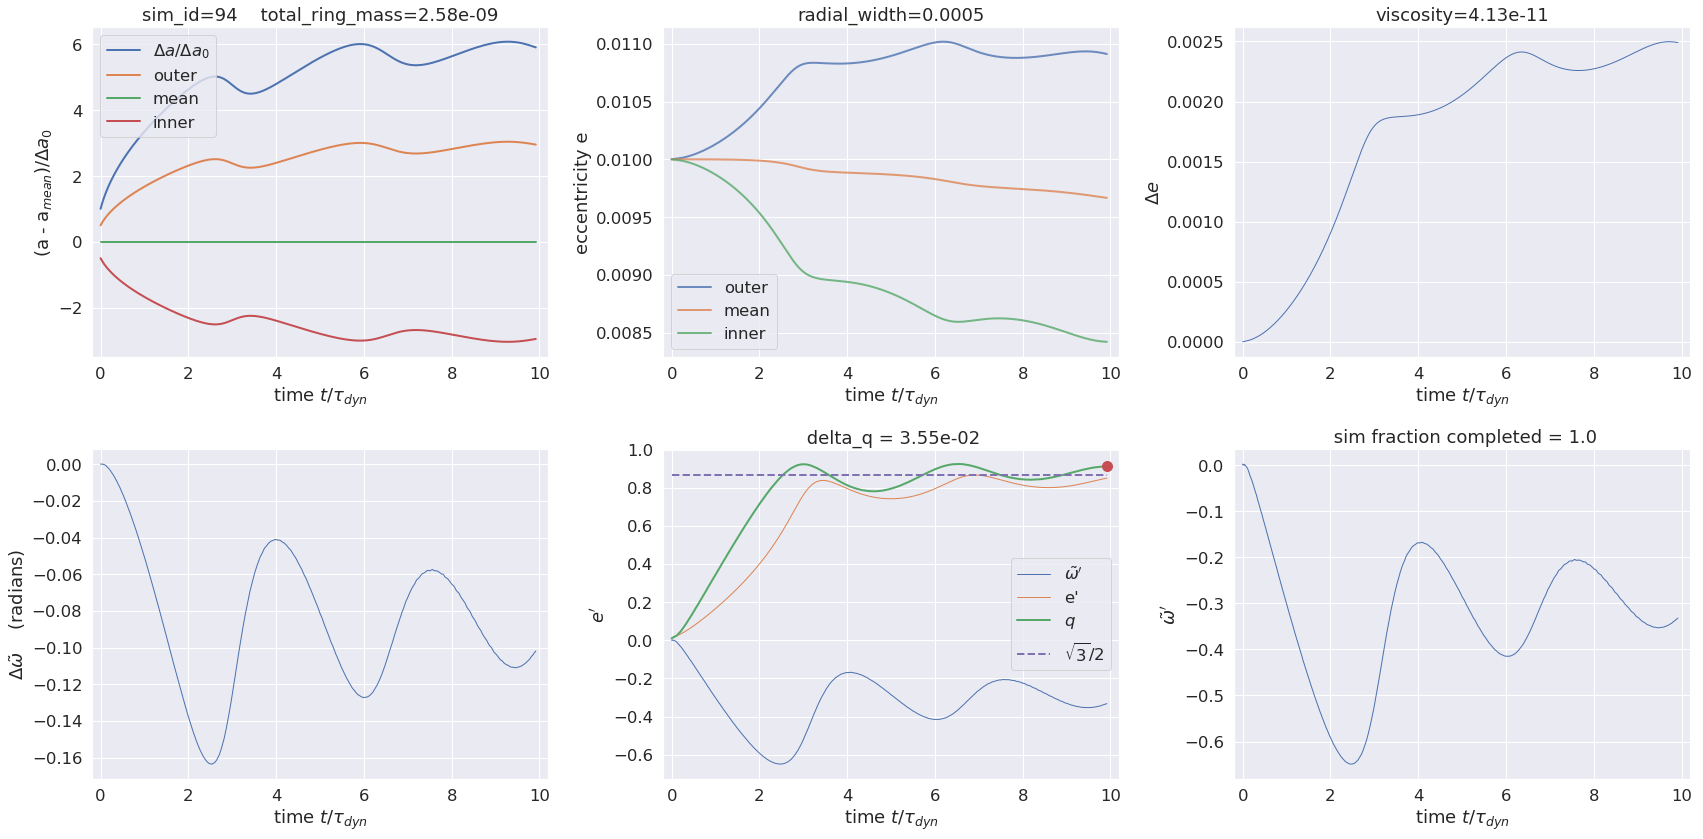

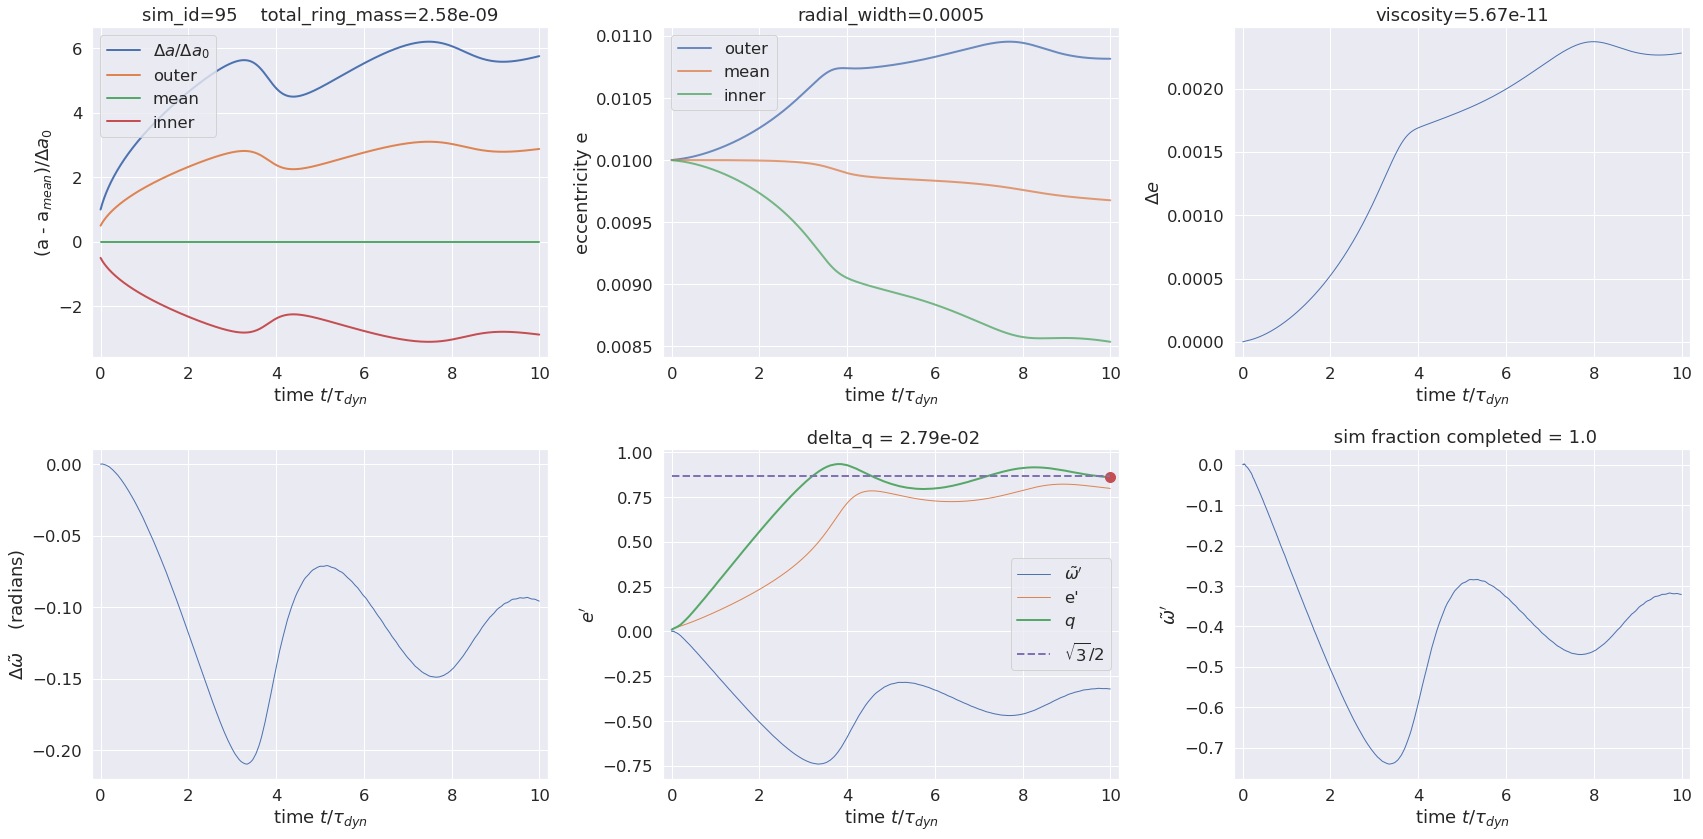

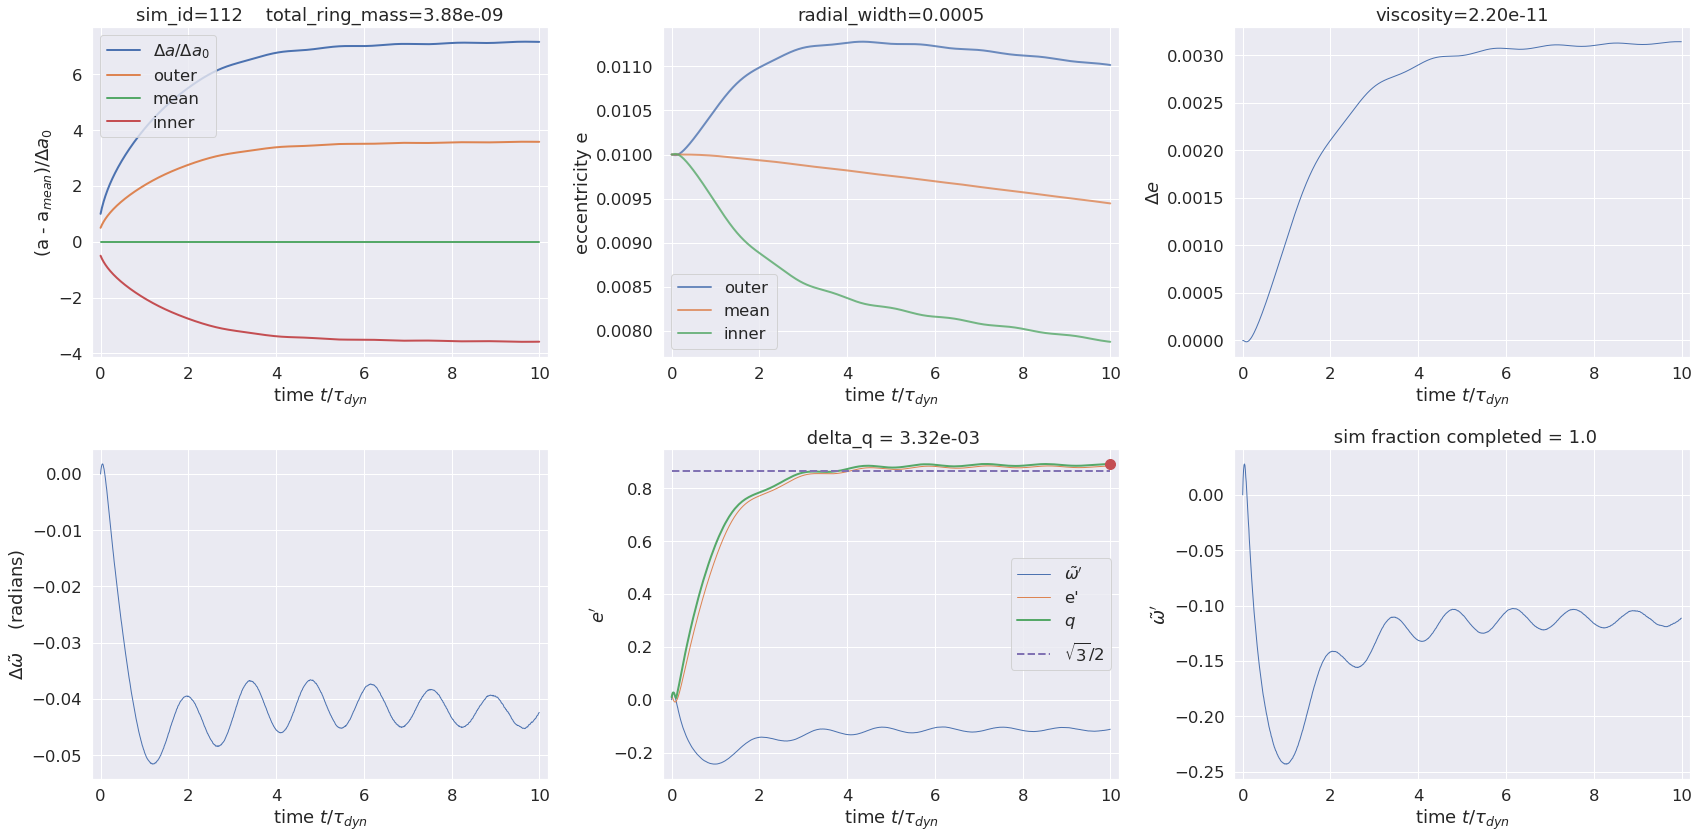

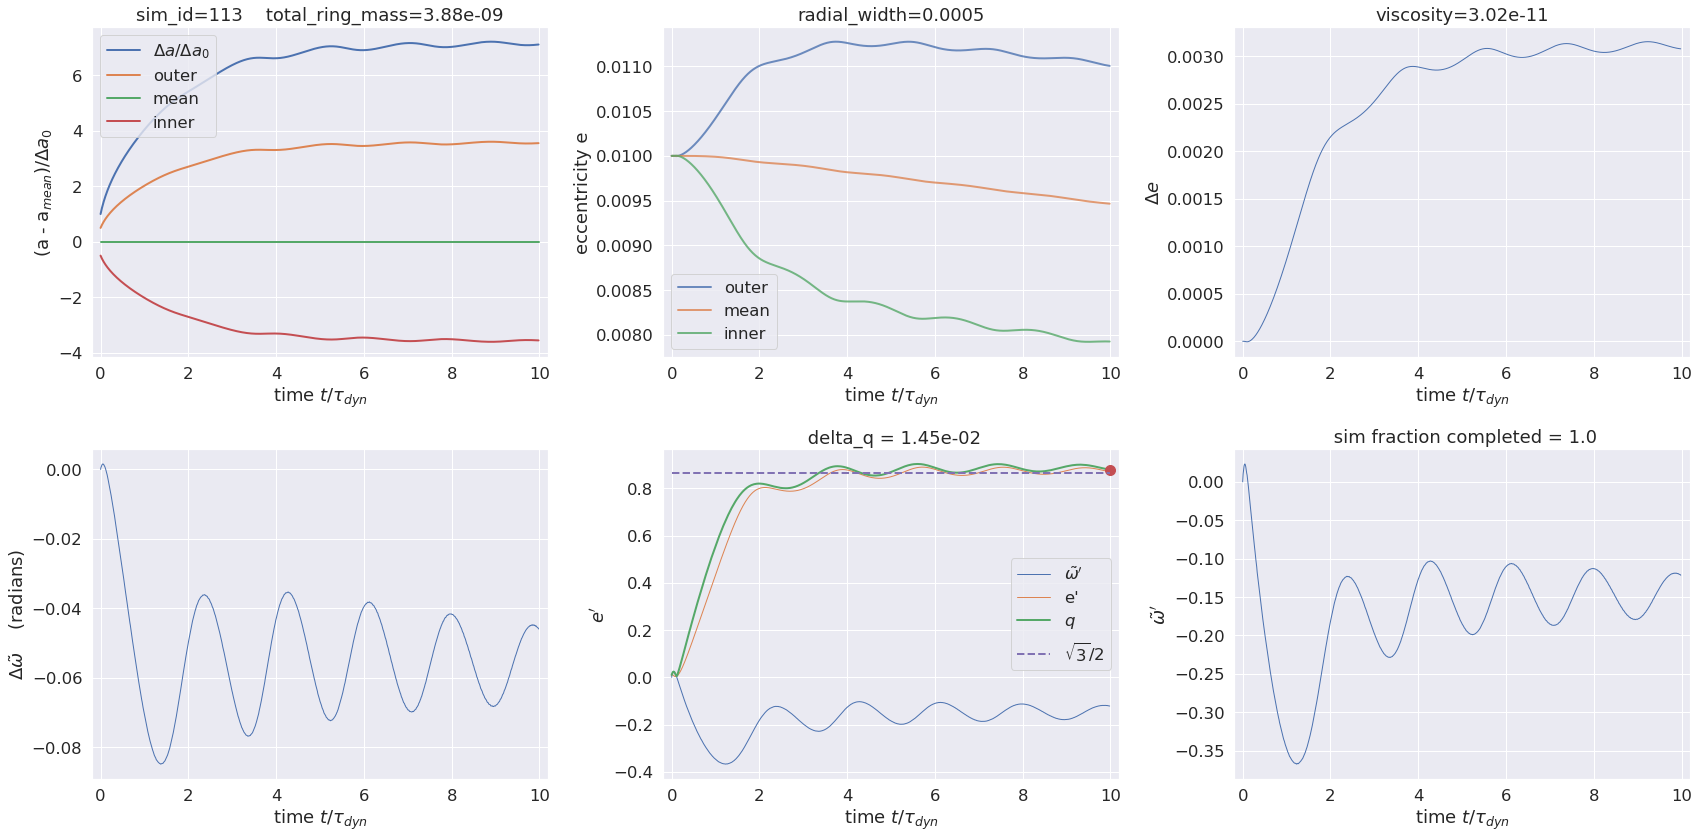

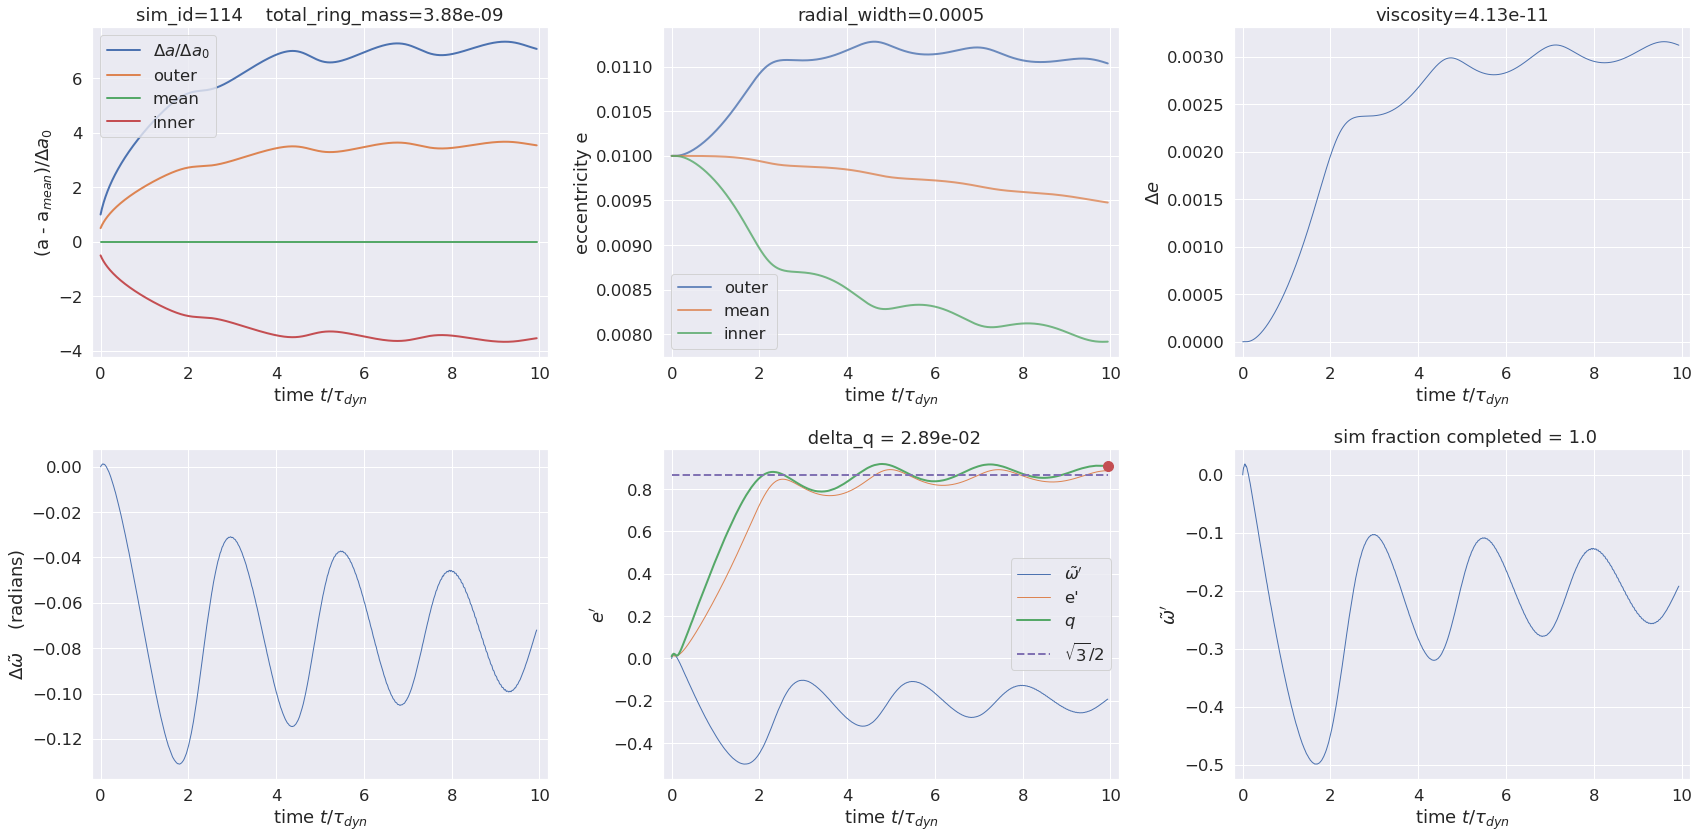

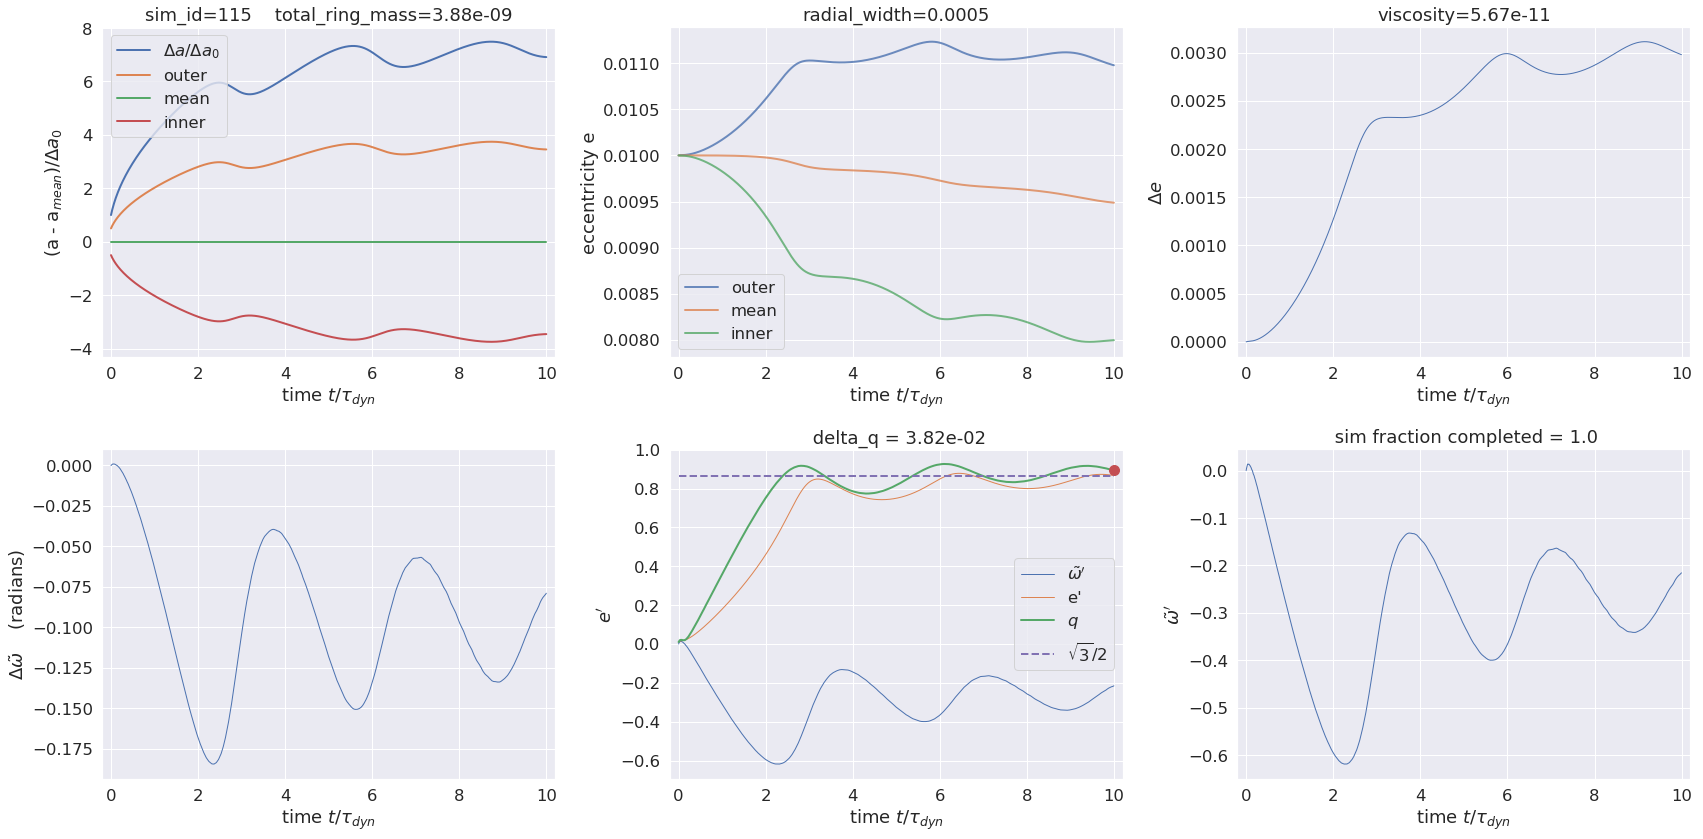

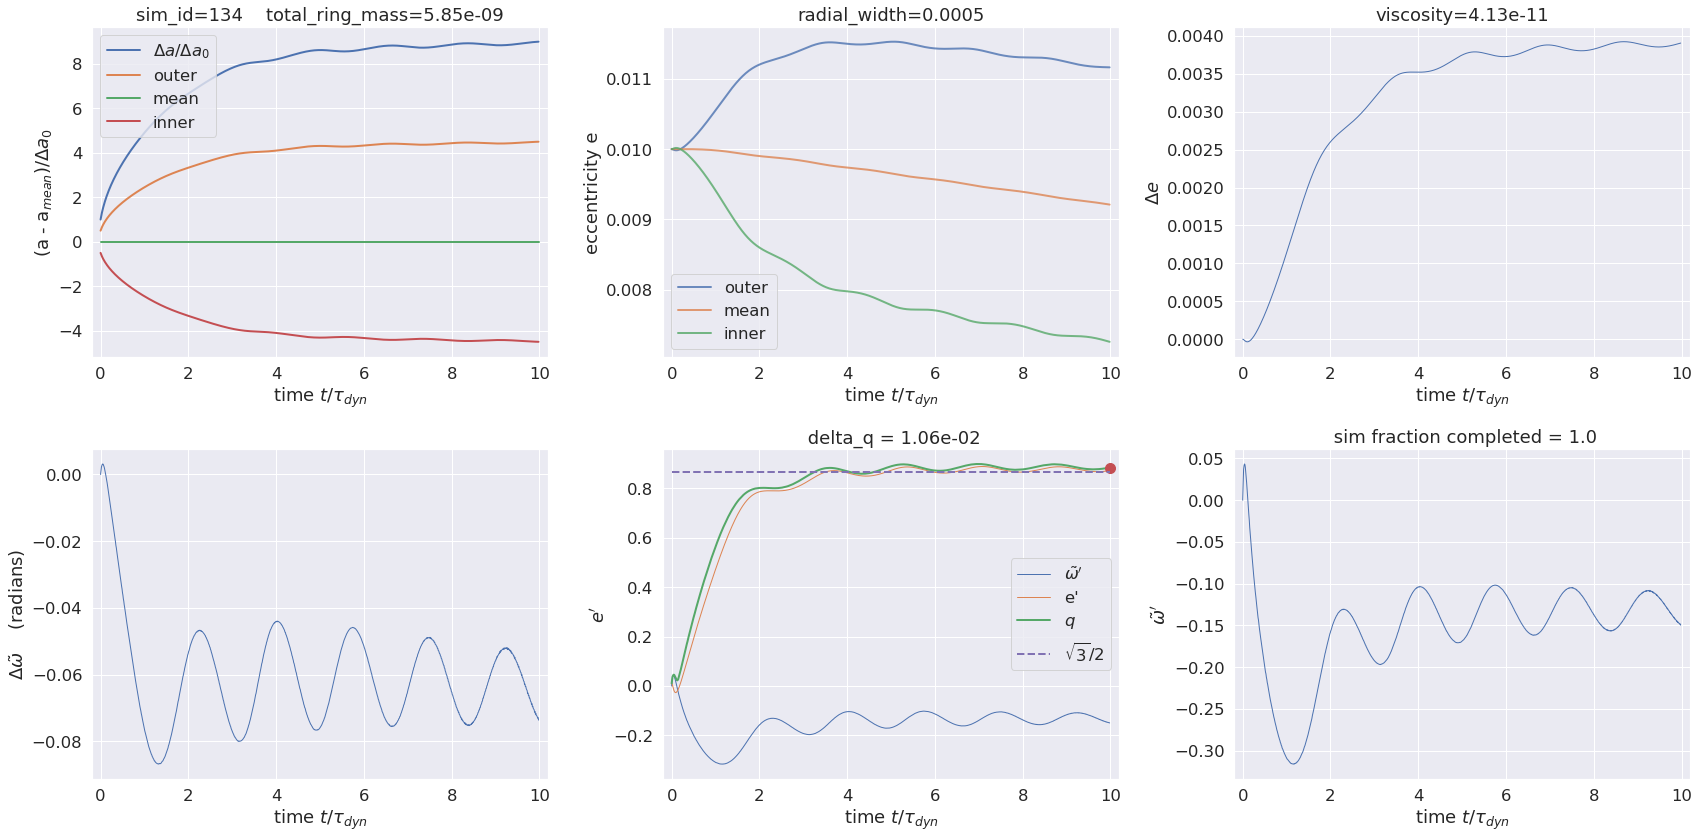

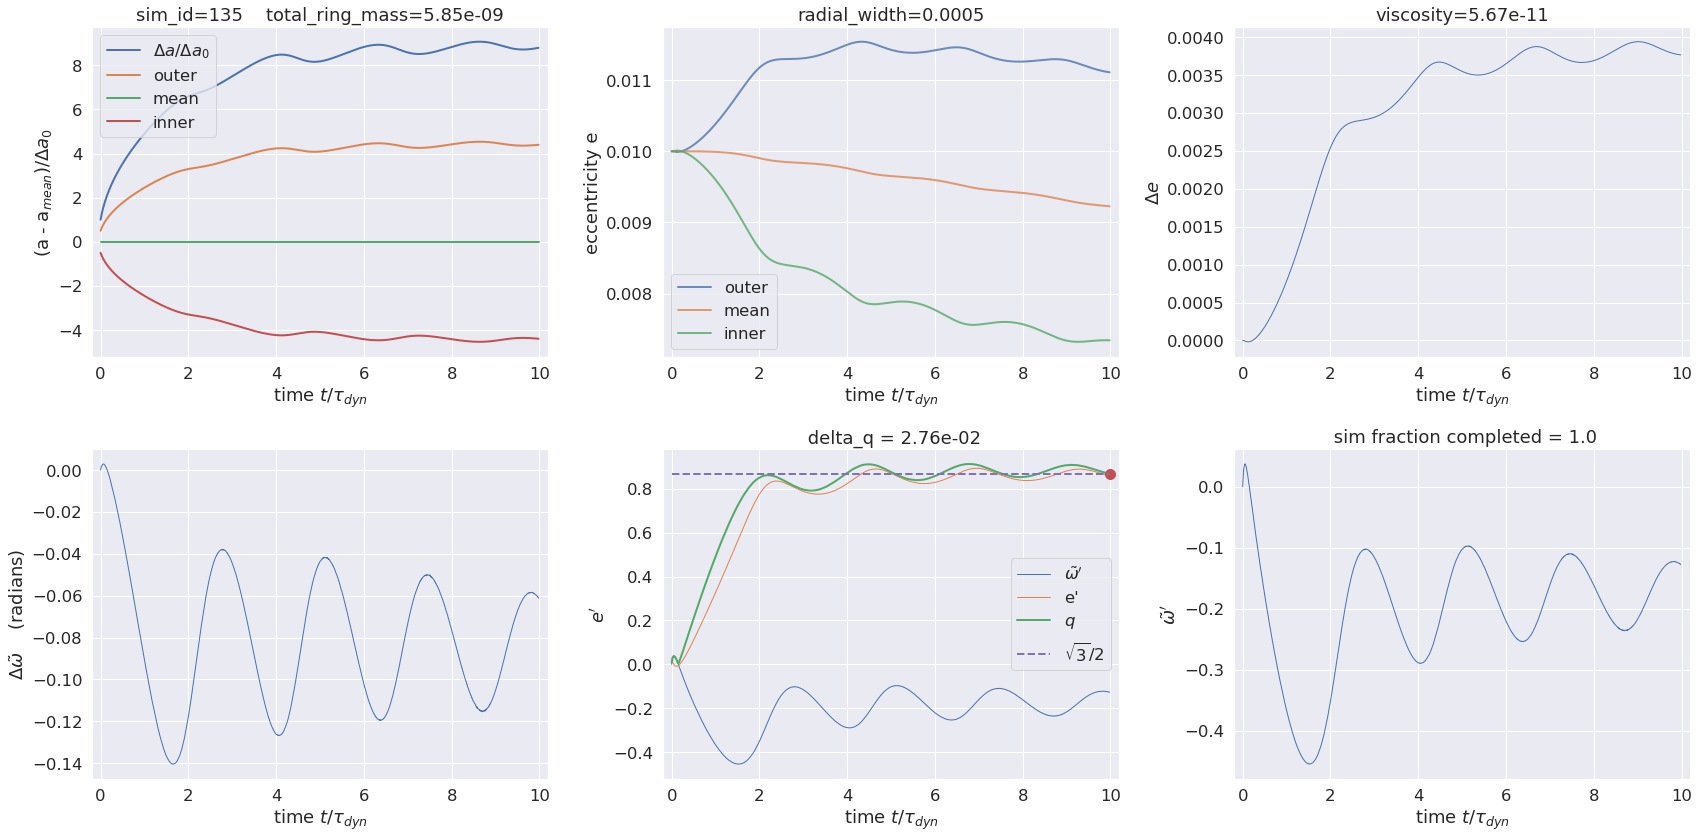

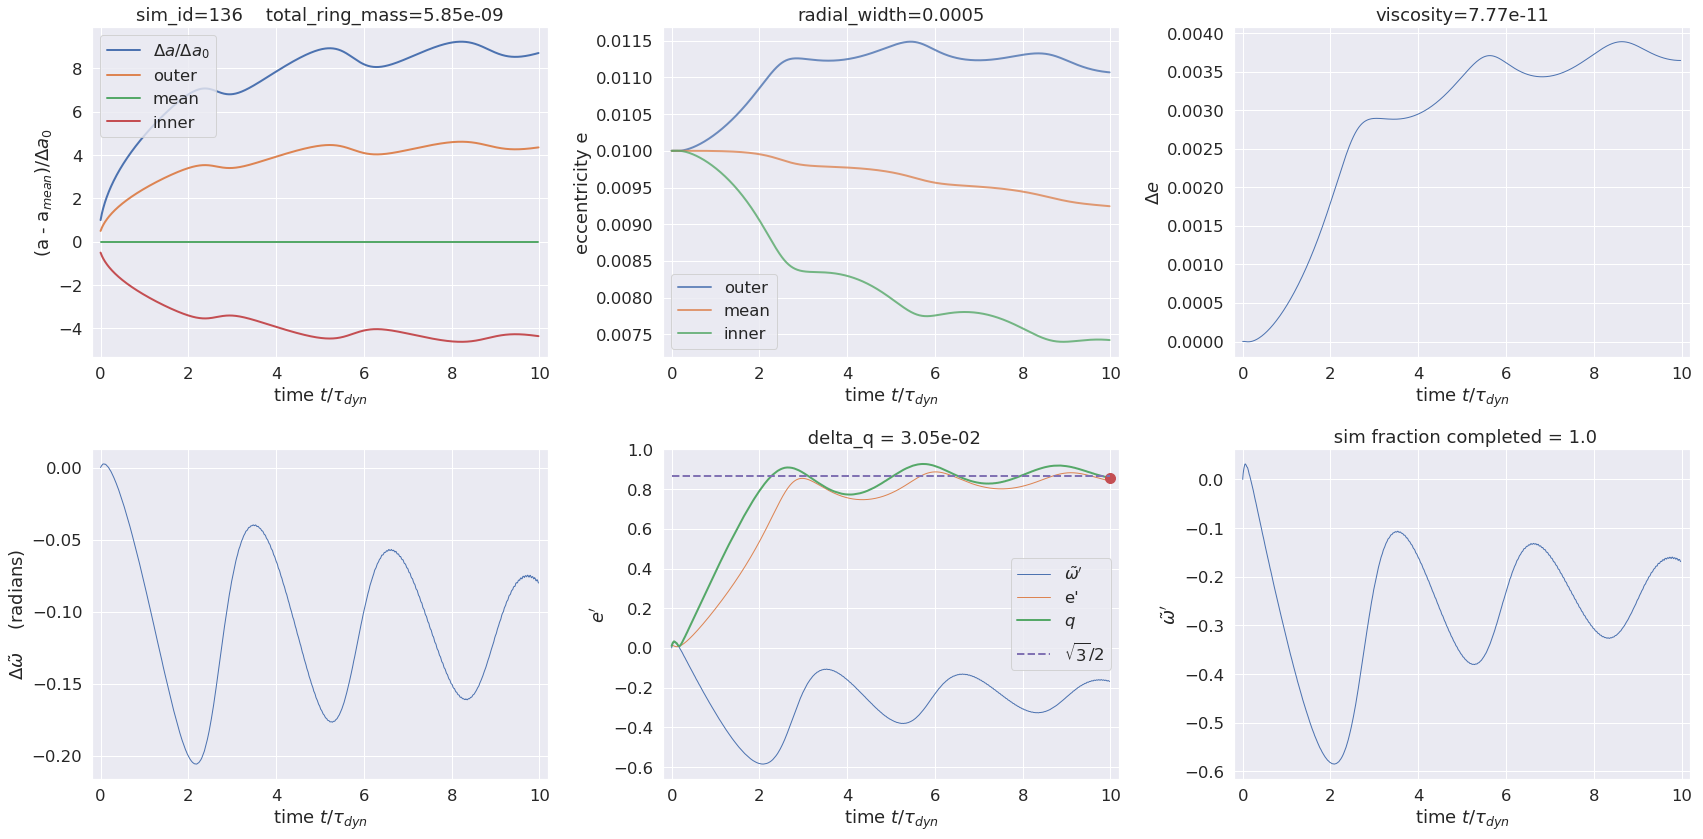

In [6]:
#generate grid of summary plots, for each sim that evolves to completion with low |wt_prime|
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.2e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + '{:.2e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.2e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'times_dynamical_max', 
    'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime', 'path']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [7]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep)
print 'fraction of sims that execute to completion = ', idx.sum()*1.0/len(idx)
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
print 'fraction of sims that evolve to self-confining state = ', idx.sum()*1.0/len(idx)
df[idx]

fraction of sims that execute to completion =  0.275
fraction of sims that evolve to self-confining state =  0.18


sim_id  expected_timestep  current_timestep  \
2         2             878000            878000   
3         3             640000            640000   
4         4             467000            467000   
5         5             340000            340000   
6         6             248000            248000   
7         7             181000            181000   
24       24             704000            704000   
25       25             513000            513000   
26       26             374000            374000   
27       27             273000            273000   
28       28             199000            199000   
29       29             145000            145000   
46       46             564000            564000   
47       47             411000            411000   
48       48             300000            300000   
49       49             219000            219000   
50       50             159000            159000   
51       51             116000            116000   
68       68             452000            452000   
69       69             330000            330000   
70       70             240000            240000   
71       71             175000            175000   
72       72             128000            128000   
90       90             363000            363000   
91       91             264000            264000   
92       92             193000            193000   
93       93             140000            140000   
94       94             102000            102000   
95       95              75000             75000   
112     112             291000            291000   
113     113             212000            212000   
114     114             154000            154000   
115     115             113000            113000   
134     134             233000            233000   
135     135             170000            170000   
136     136             124000            124000   

     streamline_crossing_timestep  times_dynamical_max  total_ring_mass  \
2                             NaN                    9     5.000000e-10   
3                             NaN                    9     5.000000e-10   
4                             NaN                    9     5.000000e-10   
5                             NaN                    9     5.000000e-10   
6                             NaN                    9     5.000000e-10   
7                             NaN                    9     5.000000e-10   
24                            NaN                    9     7.533151e-10   
25                            NaN                    9     7.533151e-10   
26                            NaN                    9     7.533151e-10   
27                            NaN                    9     7.533151e-10   
28                            NaN                    9     7.533151e-10   
29                            NaN                    9     7.533151e-10   
46                            NaN                    9     1.134967e-09   
47                            NaN                    9     1.134967e-09   
48                            NaN                    9     1.134967e-09   
49                            NaN                    9     1.134967e-09   
50                            NaN                    9     1.134967e-09   
51                            NaN                    9     1.134967e-09   
68                            NaN                    9     1.709976e-09   
69                            NaN                    9     1.709976e-09   
70                            NaN                    9     1.709976e-09   
71                            NaN                    9     1.709976e-09   
72                            NaN                    9     1.709976e-09   
90                            NaN                    9     2.576301e-09   
91                            NaN                    9     2.576301e-09   
92                            NaN                    9     2.576301e-09   
93                            NaN                    9 

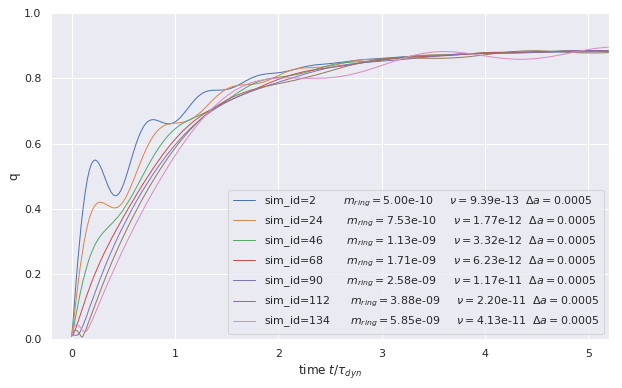

In [8]:
#for each total_ring_mass, plot q(t/t_dyn) for the sim whose viscosity yielded lowest delta_q
df = df_results
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
total_ring_masses = df.total_ring_mass.sort_values().unique()
data = []
for total_ring_mass in total_ring_masses:
    #for each total_ring_mass, find the sim whose viscosity yields lowest delta_q
    idx = (df.current_timestep == df.expected_timestep) & (df.total_ring_mass == total_ring_mass) \
        & (df.wt_prime.abs() < df.q/2)
    dfs = df[idx]
    try:
        idx = dfs.delta_q.idxmin()
        dfss = dfs.loc[idx]
        path = dfss.path
        sim_id = dfss.sim_id
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
        dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0005)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime wt_prime and q versus time
        x = times_dynamical
        y = q
        sim_id_str = str(sim_id)
        label = 'sim_id=' + sim_id_str
        label += '\t' + r'$m_{ring}=$' + '{:.2e}'.format(total_ring_mass)
        label += '\t' + r'$\nu=$' + '{:.2e}'.format(shear_viscosity)
        label += '\t' + r'$\Delta a =$' + str(radial_width)
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend()
        data += [dfss.to_dict()]
    except:
        pass
mass_viscosity = pd.DataFrame(data).sort_values('shear_viscosity')

In [9]:
#mass_viscosity
df_results.head()

sim_id  expected_timestep  current_timestep  streamline_crossing_timestep  \
0       0            1649000            989400                      935972.0   
1       1            1203000           1022550                      969279.0   
2       2             878000            878000                           NaN   
3       3             640000            640000                           NaN   
4       4             467000            467000                           NaN   

   times_dynamical_max  total_ring_mass  radial_width  shear_viscosity  \
0                    5     5.000000e-10        0.0005     5.000000e-13   
1                    8     5.000000e-10        0.0005     6.853628e-13   
2                    9     5.000000e-10        0.0005     9.394443e-13   
3                    9     5.000000e-10        0.0005     1.287720e-12   
4                    9     5.000000e-10        0.0005     1.765111e-12   

          q   delta_q  wt_prime  \
0  0.878153  0.001383 -0.122961   
1  0.882699  0.000212 -0.129545   
2  0.884724  0.000123 -0.138340   
3  0.886101  0.000134 -0.150138   
4  0.887049  0.000159 -0.165997   

                                                path  
0  permutations/total_ring_mass=4.999999999999994...  
1  permutations/total_ring_mass=4.999999999999994...  
2  permutations/total_ring_mass=4.999999999999994...  
3  permutations/total_ring_mass=4.999999999999994...  
4  permutations/total_ring_mass=4.999999999999994...

coeffs =  [ 0.64989406 -3.41857987]
power_law exponent =  0.666666666667


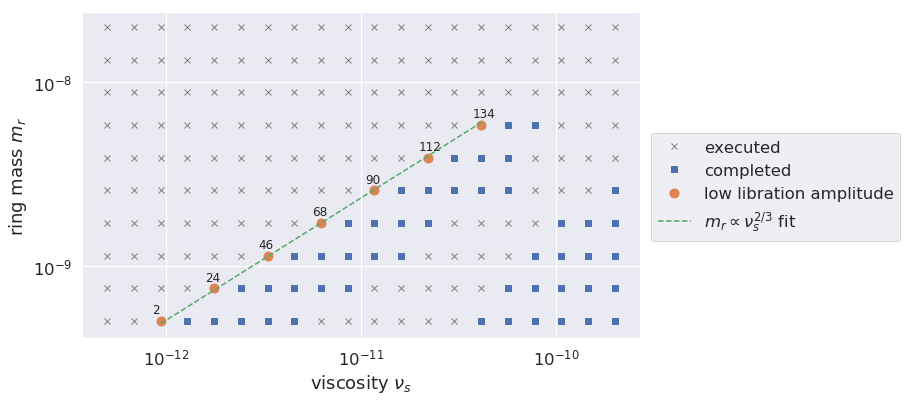

In [10]:
#show simulation outcomes
df = df_results
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#indicate sims that didnt complete
idx = (df.current_timestep < df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=6, color='grey', label='executed')
#indicate sims that completed
idx = (df.current_timestep == df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='s', markersize=6, label='completed')
#low libration sims
df = mass_viscosity
xp = df.shear_viscosity.values
yp = df.total_ring_mass.values
sim_id = df.sim_id.astype(str).values
p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=9, label='low libration amplitude')
for idx, x in enumerate(xp):
    s = sim_id[idx]
    xy = (0.9*xp[idx], 1.1*yp[idx])
    p = ax.annotate(s, xy, fontsize=12)
#assume power_law = 2/3
xp_log = np.log(xp)
yp_log = np.log(yp)
coeffs = np.polyfit(xp_log, yp_log, 1)
print 'coeffs = ', coeffs
power_law = 2./3.
print 'power_law exponent = ', power_law
idx = len(xp)//2
yp_fit = yp[idx]*(xp/xp[idx])**power_law
p = ax.plot(xp, yp_fit, linestyle='dashed', label=r'$m_r\propto\nu_s^{2/3}$ fit')
p = ax.set_xscale('log')
p = ax.set_yscale('log')
p = ax.set_xlabel(r'viscosity $\nu_s$')
p = ax.set_ylabel(r'ring mass $m_r$')
p = ax.legend(loc=(1.02, 0.3))

In [11]:
df = df_results
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

total_ring_mass =  [5.00000000e-10 7.53315095e-10 1.13496727e-09 1.70997595e-09
 2.57630139e-09 3.88153345e-09 5.84803548e-09 8.81082680e-09
 1.32746577e-08 2.00000000e-08]
radial_width =  [0.0005]
shear_viscosity =  [5.00000000e-13 6.85362803e-13 9.39444344e-13 1.28772042e-12
 1.76511135e-12 2.41948333e-12 3.31644775e-12 4.54593985e-12
 6.23123616e-12 8.54131497e-12 1.17077991e-11 1.60481801e-11
 2.19976514e-11 3.01527440e-11 4.13311383e-11 5.66536496e-11
 7.76566082e-11 1.06445901e-10 1.45908123e-10 2.00000000e-10]
